In [127]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM
from statsmodels.graphics.factorplots import interaction_plot

import pingouin as pg
from pingouin import ttest

from CosinorPy import file_parser, cosinor, cosinor1

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics

#dimensionality reduction
from sklearn.decomposition import PCA

#clustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from bioinfokit.visuz import cluster

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_context("poster")
sns.set_style("ticks")
sns.set(font_scale=2)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

# Get data

## Get filtered drinking data combined with RFID (already processed in other nb)

In [2]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/polysubstance_paper/data/final/clean/VDM/VDM_poly_final_clean_231103.csv'
data_VDM_start = pd.read_csv(path)
data_VDM_start = pd.DataFrame(data = data_VDM_start)
data_VDM_start['Id'] = data_VDM_start['Sex'] + '_' + data_VDM_start['IdRFID'].astype('str')

print(data_VDM_start.shape)
data_VDM_start.head()

(84467, 56)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,RFID_days,VDM_days,Processed_2023,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,VDM_day_count,VDM_min_count,VDM_sec_count,VDM_hour_count_running,VDM_min_count_running,VDM_sec_count_running,ld_seg,day,ld_cycle,ld_day,VDM_drink,Cage_VDM_update,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,VDM_RFID_timediff,VDM_RFID_timediff_bool,substance,Id
0,0,0,0,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,53,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 21:54:01,drink_1,0.021,2022-10-10 21:54:01,1.665439e+09,2022-10-10,10,21:54:01,21,54,1,0,1314,78841,-3,-126,-7619,dark_pm,0,dark,1,VDM_EtOH05,1,25.797,041AC15ED3,etoh_05,2022-10-10 21:53:51.171993600,2022-10-10 21:54:16.968993600,0.000000,same,EtOH05,male_041AC15ED3
1,1,1,1,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,72,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/11/22 03:16:20,drink_1,0.021,2022-10-11 03:16:20,1.665458e+09,2022-10-11,11,03:16:20,3,16,20,1,196,11780,3,196,11720,dark_am,1,dark,1,VDM_EtOH05,1,2.374,041AC15ED3,etoh_05,2022-10-11 03:11:22.796044800,2022-10-11 03:11:25.170044800,294.829955,diff,EtOH05,male_041AC15ED3
2,2,2,2,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,235,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/11/22 20:37:46,drink_1,0.021,2022-10-11 20:37:46,1.665521e+09,2022-10-11,11,20:37:46,20,37,46,1,1237,74266,20,1237,74206,dark_pm,1,dark,2,VDM_EtOH05,1,21.541,041AC15ED3,etoh_05,2022-10-11 20:37:28.550985600,2022-10-11 20:37:50.091985600,0.000000,same,EtOH05,male_041AC15ED3
3,3,3,3,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,263,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/13/22 13:33:35,drink_1,0.021,2022-10-13 13:33:35,1.665668e+09,2022-10-13,13,13:33:35,13,33,35,3,813,48815,61,3693,221555,light,3,light,3,VDM_EtOH05,1,3.978,041AC15ED3,etoh_05,2022-10-13 12:11:38.272963200,2022-10-13 12:11:42.250963200,4912.749036,diff,EtOH05,male_041AC15ED3
4,4,4,4,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,273,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/14/22 06:28:01,drink_1,0.021,2022-10-14 06:28:01,1.665729e+09,2022-10-14,14,06:28:01,6,28,1,4,388,23281,78,4708,282421,light,4,light,4,VDM_EtOH05,1,1.259,041AC15ED3,etoh_05,2022-10-14 06:19:52.405017600,2022-10-14 06:19:53.664017600,487.335982,diff,EtOH05,male_041AC15ED3


In [3]:
data_VDM_start.groupby(['IdRFID'])['ld_day'].max()

IdRFID
041ABFE4E6    8 
041ABFE86A    10
041ABFEA34    10
041ABFEE18    9 
041ABFFA62    10
041AC001FC    9 
041AC004D1    8 
041AC01110    10
041AC01C83    9 
041AC02E82    10
041AC02F19    8 
041AC03290    9 
041AC15DE9    10
041AC15DF7    10
041AC15E0E    8 
041AC15E98    8 
041AC15ECB    8 
041AC15ECD    8 
041AC15ED3    9 
041AC15FD5    12
041AC160C0    9 
041AC160F9    9 
041AC1617F    9 
041AC1620E    8 
041AC162AC    8 
041AC162F0    10
041AC16317    9 
041AC16321    10
041AC1635B    10
041AC1637F    10
041AC163D0    12
041AC16447    8 
041AC1646E    9 
041AC1646F    9 
041AC16486    9 
041AC16499    8 
041AC1649B    8 
041AC164CB    10
041AC16530    8 
041AC16548    12
041AC16579    12
041AC165A6    10
041AC165B6    10
041AC165C6    8 
041AC165FE    9 
041AC16672    10
041AC1667D    8 
041AC166BB    8 
041AC166C2    10
041AC166D7    9 
041AC166ED    12
041AC1677D    9 
041AC16782    9 
041AC1678E    8 
041AC1682D    9 
041AC1689B    8 
041AC168BD    9 
041AC169DC    9 
041AC16

In [4]:
#some got taken out on 8th day 
data_VDM_start = data_VDM_start[data_VDM_start['ld_day']<8]
data_VDM_start = data_VDM_start[data_VDM_start['ld_day']>0]
data_VDM_start = data_VDM_start[data_VDM_start['VDM_RFID_timediff']<3]
data_VDM_start = data_VDM_start[data_VDM_start['Cage_N']>1]

data_VDM_start['intake_ml_kg'] = data_VDM_start['value'] / (data_VDM_start['weight_pre']/1000)

data_VDM_start.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,RFID_days,VDM_days,Processed_2023,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,VDM_day_count,VDM_min_count,VDM_sec_count,VDM_hour_count_running,VDM_min_count_running,VDM_sec_count_running,ld_seg,day,ld_cycle,ld_day,VDM_drink,Cage_VDM_update,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,VDM_RFID_timediff,VDM_RFID_timediff_bool,substance,Id,intake_ml_kg
0,0,0,0,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,53,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 21:54:01,drink_1,0.021,2022-10-10 21:54:01,1.665439e+09,2022-10-10,10,21:54:01,21,54,1,0,1314,78841,-3,-126,-7619,dark_pm,0,dark,1,VDM_EtOH05,1,25.797,041AC15ED3,etoh_05,2022-10-10 21:53:51.171993600,2022-10-10 21:54:16.968993600,0.000000,same,EtOH05,male_041AC15ED3,0.739437
2,2,2,2,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,235,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/11/22 20:37:46,drink_1,0.021,2022-10-11 20:37:46,1.665521e+09,2022-10-11,11,20:37:46,20,37,46,1,1237,74266,20,1237,74206,dark_pm,1,dark,2,VDM_EtOH05,1,21.541,041AC15ED3,etoh_05,2022-10-11 20:37:28.550985600,2022-10-11 20:37:50.091985600,0.000000,same,EtOH05,male_041AC15ED3,0.739437
12,12,12,12,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,386,w_e10_f20_w_e5_f5_mf_221010.csv,1,10/11/22 05:08:47,drink_2,0.021,2022-10-11 05:08:47,1.665465e+09,2022-10-11,11,05:08:47,5,8,47,1,308,18527,5,308,18467,dark_am,1,dark,1,VDM_EtOH10,1,15.162,041AC15ED3,etoh_10,2022-10-11 05:08:45.227990400,2022-10-11 05:09:00.389990400,0.000000,same,EtOH10,male_041AC15ED3,0.739437
13,13,13,13,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,3484,w_e10_f20_w_e5_f5_mf_221010.csv,1,10/12/22 21:08:31,drink_2,0.021,2022-10-12 21:08:31,1.665609e+09,2022-10-12,12,21:08:31,21,8,31,2,1268,76111,45,2708,162451,dark_pm,2,dark,3,VDM_EtOH10,1,0.075,041AC15ED3,etoh_10,2022-10-12 21:08:30.294988800,2022-10-12 21:08:30.369988800,0.630011,diff,EtOH10,male_041AC15ED3,0.739437
14,14,14,14,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,9756,w_e10_f20_w_e5_f5_mf_221010.csv,1,10/13/22 21:27:42,drink_2,0.021,2022-10-13 21:27:42,1.665696e+09,2022-10-13,13,21:27:42,21,27,42,3,1287,77262,69,4167,250002,dark_pm,3,dark,4,VDM_EtOH10,1,18.466,041AC15ED3,etoh_10,2022-10-13 21:27:37.946966400,2022-10-13 21:27:56.412966400,0.000000,same,EtOH10,male_041AC15ED3,0.739437


In [5]:
hour_to_zeit = {0:19,
                1:20,
                2:21,
                3:22,
                4:23,
                5:24,
                6:1,
                7:2,
                8:3,
                9:4,
                10:5,
                11:6,
                12:7,
                13:8,
                14:9,
                15:10,
                16:11,
                17:12,
                18:13,
                19:14,
                20:15,
                21:16,
                22:17,
                23:18,
               }

data_VDM_start['zeitgeber'] = data_VDM_start['VDM_hour'].map(hour_to_zeit)

In [6]:
zeit_to_quart = {0:1,
                 1:1,
                 2:1,
                 3:1,
                 4:1,
                 5:1,
                 6:2,
                 7:2,
                 8:2,
                 9:2,
                 10:2,
                 11:2,
                 12:3,
                 13:3,
                 14:3,
                 15:3,
                 16:3,
                 17:3,
                 18:4,
                 19:4,
                 20:4,
                 21:4,
                 22:4,
                 23:4,
                 }

data_VDM_start['zeit_quart'] = data_VDM_start['zeitgeber'].map(zeit_to_quart)

In [7]:
len(data_VDM_start[data_VDM_start['Sex']=='female']['IdRFID'].unique())

24

In [8]:
len(data_VDM_start[data_VDM_start['Sex']=='male']['IdRFID'].unique())

32

In [9]:
data_VDM_start.shape

(46091, 59)

In [10]:
data_VDM_total_ld_day_hour = data_VDM_start.groupby(['IdRFID', 'Sex', 'substance', 'ld_cycle', 'zeitgeber', 'ld_day',
                                   ])['intake_ml_kg'].sum().reset_index()

print(data_VDM_total_ld_day_hour.shape)
data_VDM_total_ld_day_hour.head()

(6561, 7)


,IdRFID,Sex,substance,ld_cycle,zeitgeber,ld_day,intake_ml_kg
0,041ABFE4E6,male,EtOH05,dark,15,2,0.761246
1,041ABFE4E6,male,EtOH10,dark,15,4,0.830450
2,041ABFE4E6,male,EtOH10,dark,15,5,0.830450
3,041ABFE4E6,male,Fent05,dark,14,2,0.934256
4,041ABFE4E6,male,Fent05,dark,15,2,0.934256


In [11]:
substances = ['water', 'EtOH05', 'EtOH10', 'Fent05', 'Fent20']
data_final = pd.DataFrame()

for IdRFID in data_VDM_total_ld_day_hour['IdRFID'].unique():
    print(IdRFID)
    
    d_animal = data_VDM_total_ld_day_hour[data_VDM_total_ld_day_hour['IdRFID']==IdRFID]
    
    for substance in substances:
        
        days_hours_df = pd.DataFrame(0, index=np.arange(1,8), columns=data_VDM_start['zeitgeber'].unique()).unstack().reset_index()
        days_hours_df.columns = ['zeitgeber', 'ld_day', 'ddd']
        days_hours_df['ld_cycle'] = ['light' if x<13 else 'dark' for x in days_hours_df['zeitgeber']]
        days_hours_df['substance'] = substance
        days_hours_df['IdRFID'] = IdRFID
        days_hours_df['Sex'] = d_animal['Sex'].values[0]
        
        x = days_hours_df.merge(d_animal, on=['IdRFID', 'Sex', 'ld_day', 'ld_cycle', 'zeitgeber', 'substance'], 
                                how='left').sort_values(['substance', 'ld_day', 'zeitgeber'])
        
        if data_final.empty:
            data_final = x
        else:
            data_final = pd.concat([data_final, x], axis=0)
        
    print(data_final.shape,'\n')

data_final = data_final.fillna(0).sort_values(['IdRFID', 'substance', 'ld_day', 'zeitgeber'])
data_final.head()

041ABFE4E6
(840, 8) 

041ABFE86A
(1680, 8) 

041ABFEA34
(2520, 8) 

041ABFEE18
(3360, 8) 

041ABFFA62
(4200, 8) 

041AC001FC
(5040, 8) 

041AC004D1
(5880, 8) 

041AC01110
(6720, 8) 

041AC02E82
(7560, 8) 

041AC02F19
(8400, 8) 

041AC15DE9
(9240, 8) 

041AC15DF7
(10080, 8) 

041AC15E0E
(10920, 8) 

041AC15E98
(11760, 8) 

041AC15ECB
(12600, 8) 

041AC15ECD
(13440, 8) 

041AC15ED3
(14280, 8) 

041AC15FD5
(15120, 8) 

041AC160C0
(15960, 8) 

041AC1617F
(16800, 8) 

041AC1620E
(17640, 8) 

041AC162AC
(18480, 8) 

041AC162F0
(19320, 8) 

041AC16317
(20160, 8) 

041AC16321
(21000, 8) 

041AC1635B
(21840, 8) 

041AC1637F
(22680, 8) 

041AC16447
(23520, 8) 

041AC1646E
(24360, 8) 

041AC1646F
(25200, 8) 

041AC16486
(26040, 8) 

041AC16499
(26880, 8) 

041AC1649B
(27720, 8) 

041AC164CB
(28560, 8) 

041AC16530
(29400, 8) 

041AC16548
(30240, 8) 

041AC165A6
(31080, 8) 

041AC165B6
(31920, 8) 

041AC165C6
(32760, 8) 

041AC165FE
(33600, 8) 

041AC16672
(34440, 8) 

041AC1667D
(35280, 8) 

041A

,zeitgeber,ld_day,ddd,ld_cycle,substance,IdRFID,Sex,intake_ml_kg
56,1,1,0,light,EtOH05,041ABFE4E6,male,0.0
126,2,1,0,light,EtOH05,041ABFE4E6,male,0.0
63,3,1,0,light,EtOH05,041ABFE4E6,male,0.0
98,4,1,0,light,EtOH05,041ABFE4E6,male,0.0
140,5,1,0,light,EtOH05,041ABFE4E6,male,0.0


In [12]:
zeit_to_quart = {0:1,
                 1:1,
                 2:1,
                 3:1,
                 4:1,
                 5:1,
                 6:2,
                 7:2,
                 8:2,
                 9:2,
                 10:2,
                 11:2,
                 12:3,
                 13:3,
                 14:3,
                 15:3,
                 16:3,
                 17:3,
                 18:4,
                 19:4,
                 20:4,
                 21:4,
                 22:4,
                 23:4,
                 }

data_final['zeit_quart'] = data_final['zeitgeber'].map(zeit_to_quart)

data_final.head()

,zeitgeber,ld_day,ddd,ld_cycle,substance,IdRFID,Sex,intake_ml_kg,zeit_quart
56,1,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0
126,2,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0
63,3,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0
98,4,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0
140,5,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0


## Get RFID data (already processed in other nb)

In [13]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/polysubstance_paper/data/final/clean/RFID/RFID_poly_final_clean_231103.csv'

data_RFID_start = pd.read_csv(path)
data_RFID_start = pd.DataFrame(data = data_RFID_start)
print(data_RFID_start.shape)
data_RFID_start.head()

(689058, 34)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,weight_post,weight_diff,notes
0,0,0,0,poly,na,1,041AC15FD5,1866.0,na,male,3,fent_05,Spyder1.10,1.474,light,0,0,15,14,24,2022-06-01 15:14:24.644976000,2022-06-01 15:14:26.118976000,15:14:24,15:14:26,914,54864,-9,-526,-31596,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
1,1,1,1,poly,na,1,041AC15FD5,1866.0,na,male,3,water_2,Spyder1.05,1.832,light,0,0,15,15,6,2022-06-01 15:15:06.097017600,2022-06-01 15:15:07.929017600,15:15:06,15:15:07,915,54906,-9,-525,-31554,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
2,2,2,2,poly,na,1,041AC15FD5,1866.0,na,male,3,fent_05,Spyder1.04,0.887,light,0,0,15,15,44,2022-06-01 15:15:44.613014400,2022-06-01 15:15:45.500014400,15:15:44,15:15:45,915,54944,-9,-525,-31516,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
3,3,3,3,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,0.414,light,0,0,15,16,6,2022-06-01 15:16:06.479990400,2022-06-01 15:16:06.893990400,15:16:06,15:16:06,916,54966,-9,-524,-31494,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
4,4,4,4,poly,na,1,041AC15FD5,1866.0,na,male,3,fent_20,Spyder1.01,2.777,light,0,0,15,16,18,2022-06-01 15:16:18.455980800,2022-06-01 15:16:21.232980800,15:16:18,15:16:21,916,54978,-9,-524,-31482,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN


In [14]:
data_RFID_start.groupby(['IdRFID'])['ld_day'].max()

IdRFID
041ABFE4E6    8 
041ABFE86A    10
041ABFEA34    10
041ABFEE18    9 
041ABFFA62    10
041AC001FC    9 
041AC004D1    8 
041AC01110    10
041AC01C83    9 
041AC02E82    10
041AC02F19    8 
041AC03290    9 
041AC15DE9    10
041AC15DF7    10
041AC15E0E    8 
041AC15E98    8 
041AC15ECB    8 
041AC15ECD    8 
041AC15ED3    9 
041AC15FD5    12
041AC160C0    9 
041AC160F9    9 
041AC1617F    9 
041AC1620E    8 
041AC162AC    8 
041AC162F0    10
041AC16317    9 
041AC16321    10
041AC1635B    10
041AC1637F    10
041AC163D0    12
041AC16447    8 
041AC1646E    9 
041AC1646F    9 
041AC16486    9 
041AC16499    8 
041AC1649B    8 
041AC164CB    10
041AC16530    8 
041AC16548    12
041AC16579    12
041AC165A6    10
041AC165B6    10
041AC165C6    8 
041AC165FE    9 
041AC16672    10
041AC1667D    8 
041AC166BB    8 
041AC166C2    10
041AC166D7    9 
041AC166ED    12
041AC1677D    9 
041AC16782    9 
041AC1678E    8 
041AC1682D    9 
041AC1689B    8 
041AC168BD    9 
041AC169DC    9 
041AC16

In [15]:
#some got taken out on 8th day so end at lights on day 8
data_RFID_start = data_RFID_start[data_RFID_start['ld_day']<8]
data_RFID_start = data_RFID_start[data_RFID_start['ld_day']>0]

data_RFID_start = data_RFID_start[data_RFID_start['Cage_N']>1]
print(data_RFID_start.shape)
data_RFID_start.head()

(418699, 34)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,weight_post,weight_diff,notes
231,231,231,231,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,23.391,dark,1,0,18,0,23,2022-06-01 18:00:23.085993600,2022-06-01 18:00:46.476993600,18:00:23,18:00:46,1080,64823,-6,-360,-21637,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
232,232,232,232,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,3.372,dark,1,0,18,0,47,2022-06-01 18:00:47.591971200,2022-06-01 18:00:50.963971200,18:00:47,18:00:50,1080,64847,-6,-360,-21613,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
233,233,233,233,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,1.743,dark,1,0,18,0,52,2022-06-01 18:00:52.367040000,2022-06-01 18:00:54.110040000,18:00:52,18:00:54,1080,64852,-6,-360,-21608,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
234,234,234,234,poly,na,1,041AC15FD5,1866.0,na,male,3,fent_20,Spyder1.01,16.418,dark,1,0,18,8,21,2022-06-01 18:08:21.301958400,2022-06-01 18:08:37.719958400,18:08:21,18:08:37,1088,65301,-6,-352,-21159,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN
235,235,235,235,poly,na,1,041AC15FD5,1866.0,na,male,3,water_1,Spyder1.02,3.860,dark,1,0,18,9,18,2022-06-01 18:09:18.525024000,2022-06-01 18:09:22.385024000,18:09:18,18:09:22,1089,65358,-6,-351,-21102,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN


In [16]:
hour_to_zeit = {0:19,
                1:20,
                2:21,
                3:22,
                4:23,
                5:24,
                6:1,
                7:2,
                8:3,
                9:4,
                10:5,
                11:6,
                12:7,
                13:8,
                14:9,
                15:10,
                16:11,
                17:12,
                18:13,
                19:14,
                20:15,
                21:16,
                22:17,
                23:18,
               }

data_RFID_start['zeitgeber'] = data_RFID_start['RFID_hour'].map(hour_to_zeit)

In [17]:
zeit_to_quart = {0:1,
                 1:1,
                 2:1,
                 3:1,
                 4:1,
                 5:1,
                 6:2,
                 7:2,
                 8:2,
                 9:2,
                 10:2,
                 11:2,
                 12:3,
                 13:3,
                 14:3,
                 15:3,
                 16:3,
                 17:3,
                 18:4,
                 19:4,
                 20:4,
                 21:4,
                 22:4,
                 23:4,
                 }

data_RFID_start['zeit_quart'] = data_RFID_start['zeitgeber'].map(zeit_to_quart)

data_RFID_start.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,weight_post,weight_diff,notes,zeitgeber,zeit_quart
231,231,231,231,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,23.391,dark,1,0,18,0,23,2022-06-01 18:00:23.085993600,2022-06-01 18:00:46.476993600,18:00:23,18:00:46,1080,64823,-6,-360,-21637,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN,13,3.0
232,232,232,232,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,3.372,dark,1,0,18,0,47,2022-06-01 18:00:47.591971200,2022-06-01 18:00:50.963971200,18:00:47,18:00:50,1080,64847,-6,-360,-21613,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN,13,3.0
233,233,233,233,poly,na,1,041AC15FD5,1866.0,na,male,3,etoh_10,Spyder1.03,1.743,dark,1,0,18,0,52,2022-06-01 18:00:52.367040000,2022-06-01 18:00:54.110040000,18:00:52,18:00:54,1080,64852,-6,-360,-21608,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN,13,3.0
234,234,234,234,poly,na,1,041AC15FD5,1866.0,na,male,3,fent_20,Spyder1.01,16.418,dark,1,0,18,8,21,2022-06-01 18:08:21.301958400,2022-06-01 18:08:37.719958400,18:08:21,18:08:37,1088,65301,-6,-352,-21159,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN,13,3.0
235,235,235,235,poly,na,1,041AC15FD5,1866.0,na,male,3,water_1,Spyder1.02,3.860,dark,1,0,18,9,18,2022-06-01 18:09:18.525024000,2022-06-01 18:09:22.385024000,18:09:18,18:09:22,1089,65358,-6,-351,-21102,Idspyder-22.06.01.csv,32.0,NaN,NaN,NaN,13,3.0


## Confirm matching RFIDs 

In [18]:
set(data_RFID_start['IdRFID'].unique()) - set(data_VDM_start['IdRFID'].unique())

set()

In [19]:
set(data_VDM_start['IdRFID'].unique()) - set(data_RFID_start['IdRFID'].unique())

set()

In [20]:
sub_map = {'etoh_05': 'EtOH05',
           'etoh_10': 'EtOH10',
           'fent_05': 'Fent05',
           'fent_20': 'Fent20',
           'water_1': 'water',
           'water_2': 'water',}

data_RFID_start['substance'] = data_RFID_start['unitLabel_drink'].map(sub_map)

In [21]:
data_RFID_total_ld_day_hour = data_RFID_start.groupby(['IdRFID', 'Sex', 'substance', 'ld_cycle', 'zeitgeber', 'ld_day',
                                   ])['eventDuration'].sum().reset_index()

print(data_RFID_total_ld_day_hour.shape)
data_RFID_total_ld_day_hour.head()

(30203, 7)


,IdRFID,Sex,substance,ld_cycle,zeitgeber,ld_day,eventDuration
0,041ABFE4E6,male,EtOH05,dark,13,1,54.216
1,041ABFE4E6,male,EtOH05,dark,13,2,68.672
2,041ABFE4E6,male,EtOH05,dark,13,3,32.353
3,041ABFE4E6,male,EtOH05,dark,13,4,2.771
4,041ABFE4E6,male,EtOH05,dark,13,5,2.746


In [22]:
substances = ['water', 'EtOH05', 'EtOH10', 'Fent05', 'Fent20']
data_RFID_final = pd.DataFrame()

for IdRFID in data_RFID_total_ld_day_hour['IdRFID'].unique():
    print(IdRFID)
    
    d_animal = data_RFID_total_ld_day_hour[data_RFID_total_ld_day_hour['IdRFID']==IdRFID]
    
    for substance in substances:
        
        days_hours_df = pd.DataFrame(0, index=np.arange(1,8), columns=data_RFID_start['zeitgeber'].unique()).unstack().reset_index()
        days_hours_df.columns = ['zeitgeber', 'ld_day', 'ddd']
        days_hours_df['ld_cycle'] = ['light' if x<13 else 'dark' for x in days_hours_df['zeitgeber']]
        days_hours_df['substance'] = substance
        days_hours_df['IdRFID'] = IdRFID
        days_hours_df['Sex'] = d_animal['Sex'].values[0]
        
        x = days_hours_df.merge(d_animal, on=['IdRFID', 'Sex', 'ld_day', 'ld_cycle', 'zeitgeber', 'substance'], 
                                how='left').sort_values(['substance', 'ld_day', 'zeitgeber'])
        
        if data_RFID_final.empty:
            data_RFID_final = x
        else:
            data_RFID_final = pd.concat([data_RFID_final, x], axis=0)
        
    print(data_RFID_final.shape,'\n')

data_RFID_final = data_RFID_final.fillna(0).sort_values(['IdRFID', 'substance', 'ld_day', 'zeitgeber'])
data_RFID_final.head()

041ABFE4E6
(840, 8) 

041ABFE86A
(1680, 8) 

041ABFEA34
(2520, 8) 

041ABFEE18
(3360, 8) 

041ABFFA62
(4200, 8) 

041AC001FC
(5040, 8) 

041AC004D1
(5880, 8) 

041AC01110
(6720, 8) 

041AC02E82
(7560, 8) 

041AC02F19
(8400, 8) 

041AC15DE9
(9240, 8) 

041AC15DF7
(10080, 8) 

041AC15E0E
(10920, 8) 

041AC15E98
(11760, 8) 

041AC15ECB
(12600, 8) 

041AC15ECD
(13440, 8) 

041AC15ED3
(14280, 8) 

041AC15FD5
(15120, 8) 

041AC160C0
(15960, 8) 

041AC1617F
(16800, 8) 

041AC1620E
(17640, 8) 

041AC162AC
(18480, 8) 

041AC162F0
(19320, 8) 

041AC16317
(20160, 8) 

041AC16321
(21000, 8) 

041AC1635B
(21840, 8) 

041AC1637F
(22680, 8) 

041AC16447
(23520, 8) 

041AC1646E
(24360, 8) 

041AC1646F
(25200, 8) 

041AC16486
(26040, 8) 

041AC16499
(26880, 8) 

041AC1649B
(27720, 8) 

041AC164CB
(28560, 8) 

041AC16530
(29400, 8) 

041AC16548
(30240, 8) 

041AC165A6
(31080, 8) 

041AC165B6
(31920, 8) 

041AC165C6
(32760, 8) 

041AC165FE
(33600, 8) 

041AC16672
(34440, 8) 

041AC1667D
(35280, 8) 

041A

,zeitgeber,ld_day,ddd,ld_cycle,substance,IdRFID,Sex,eventDuration
77,1,1,0,light,EtOH05,041ABFE4E6,male,9.074
84,2,1,0,light,EtOH05,041ABFE4E6,male,0.000
91,3,1,0,light,EtOH05,041ABFE4E6,male,5.823
133,4,1,0,light,EtOH05,041ABFE4E6,male,0.000
98,5,1,0,light,EtOH05,041ABFE4E6,male,0.344


In [23]:
zeit_to_quart = {0:1,
                 1:1,
                 2:1,
                 3:1,
                 4:1,
                 5:1,
                 6:2,
                 7:2,
                 8:2,
                 9:2,
                 10:2,
                 11:2,
                 12:3,
                 13:3,
                 14:3,
                 15:3,
                 16:3,
                 17:3,
                 18:4,
                 19:4,
                 20:4,
                 21:4,
                 22:4,
                 23:4,
                 }

data_RFID_final['zeit_quart'] = data_RFID_final['zeitgeber'].map(zeit_to_quart)

data_RFID_final.head()

,zeitgeber,ld_day,ddd,ld_cycle,substance,IdRFID,Sex,eventDuration,zeit_quart
77,1,1,0,light,EtOH05,041ABFE4E6,male,9.074,1.0
84,2,1,0,light,EtOH05,041ABFE4E6,male,0.000,1.0
91,3,1,0,light,EtOH05,041ABFE4E6,male,5.823,1.0
133,4,1,0,light,EtOH05,041ABFE4E6,male,0.000,1.0
98,5,1,0,light,EtOH05,041ABFE4E6,male,0.344,1.0


# RFID data

In [24]:
data_RFID = data_RFID_final

## total with combined substances

### event duration proportion

KstestResult(statistic=0.07646202892674092, pvalue=0.0)


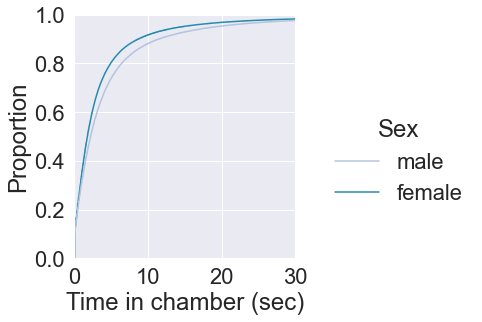

In [25]:
sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='Sex', palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,30)
plt.xlabel('Time in chamber (sec)')

m=data_RFID_start[data_RFID_start['Sex']=='male']['eventDuration'].values
f=data_RFID_start[data_RFID_start['Sex']=='female']['eventDuration'].values
print(stats.kstest(m, f))

plt.show()

### total event duration sum

In [26]:
data_RFID_total = data_RFID.groupby(['IdRFID', 'Sex', 
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total['Time in chamber (min)'] = data_RFID_total['eventDuration']/60

data_RFID_total.head()

,IdRFID,Sex,eventDuration,Time in chamber (min)
0,041ABFE4E6,male,31133.893,518.898217
1,041ABFE86A,male,21828.612,363.810200
2,041ABFEA34,female,59333.517,988.891950
3,041ABFEE18,female,39985.779,666.429650
4,041ABFFA62,female,59079.255,984.654250


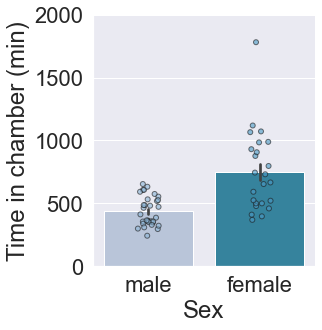

Ttest_indResult(statistic=5.124973974542231, pvalue=4.110957204358939e-06)

In [27]:
g = sns.catplot(x='Sex', y='Time in chamber (min)', data=data_RFID_total,  kind='bar', height=5, aspect=1,
            ci=68, palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'Sex', 'Time in chamber (min)', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)
plt.ylim(0,2000)
plt.show()

male = data_RFID_total[data_RFID_total['Sex']=='male']['Time in chamber (min)']
female = data_RFID_total[data_RFID_total['Sex']=='female']['Time in chamber (min)']
stats.ttest_ind(female, male)

## light dark with combined substances

### event duration proportion

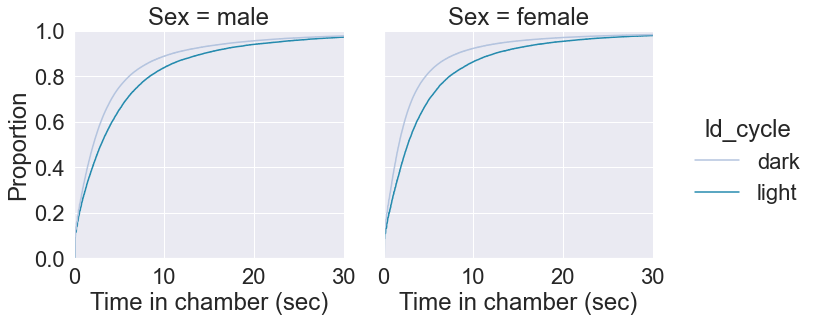

In [28]:
g=sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='ld_cycle', col='Sex', palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [29]:
data_RFID_total_ld = data_RFID.groupby(['IdRFID', 'Sex', 'ld_cycle', 
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_ld['Time in chamber (min)'] = data_RFID_total_ld['eventDuration']/60

data_RFID_total_ld.head()

,IdRFID,Sex,ld_cycle,eventDuration,Time in chamber (min)
0,041ABFE4E6,male,dark,26774.308,446.238467
1,041ABFE4E6,male,light,4359.585,72.659750
2,041ABFE86A,male,dark,18711.761,311.862683
3,041ABFE86A,male,light,3116.851,51.947517
4,041ABFEA34,female,dark,51561.580,859.359667


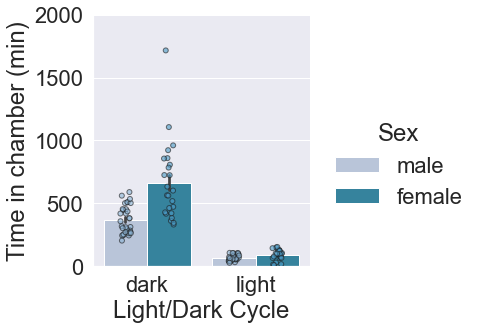

In [30]:
g= sns.catplot(x='ld_cycle', y='Time in chamber (min)', data=data_RFID_total_ld,  kind='bar', height=5, aspect=1,
            ci=68, hue='Sex', palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'ld_cycle', 'Time in chamber (min)', 'Sex',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)
plt.ylim(0,2000)
plt.xlabel('Light/Dark Cycle')
plt.show()

In [31]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_cycle', between='Sex', subject='IdRFID', data=data_RFID_total_ld)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_cycle', between='Sex',
                              subject='IdRFID', data=data_RFID_total_ld, padjust='bonf')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                SS    DF1    DF2           MS        F    p-unc    np2      eps
-----------  -----------  -----  -----  -----------  -------  -------  -----  -------
Sex           684836.605      1     54   684836.605   26.265    0.000  0.327  nan
ld_cycle     4917653.693      1     54  4917653.693  206.251    0.000  0.793    1.000
Interaction   521627.272      1     54   521627.272   21.878    0.000  0.288  nan


POST HOC TESTS

Contrast        ld_cycle    A     B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust                   BF10    hedges
--------------  ----------  ----  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  -------------------  --------
ld_cycle        -           dark  light   True      True          12.227  55.000  two-sided    0.000   nan      nan         227000000000000.000     2.210
Sex             -           male  female  False     True          -4.576  27.437  

## daily total with combined substance 

### event duration proportion

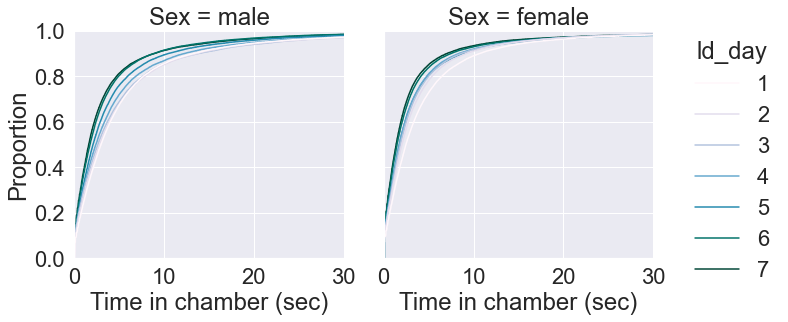

In [32]:
g=sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='ld_day', col='Sex', palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [33]:
data_RFID_total_daily = data_RFID.groupby(['IdRFID', 'Sex', 'ld_day',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_daily['Time in chamber (min)'] = data_RFID_total_daily['eventDuration']/60

data_RFID_total_daily.head()

,IdRFID,Sex,ld_day,eventDuration,Time in chamber (min)
0,041ABFE4E6,male,1,6546.483,109.108050
1,041ABFE4E6,male,2,5569.302,92.821700
2,041ABFE4E6,male,3,4080.473,68.007883
3,041ABFE4E6,male,4,3097.784,51.629733
4,041ABFE4E6,male,5,4329.275,72.154583


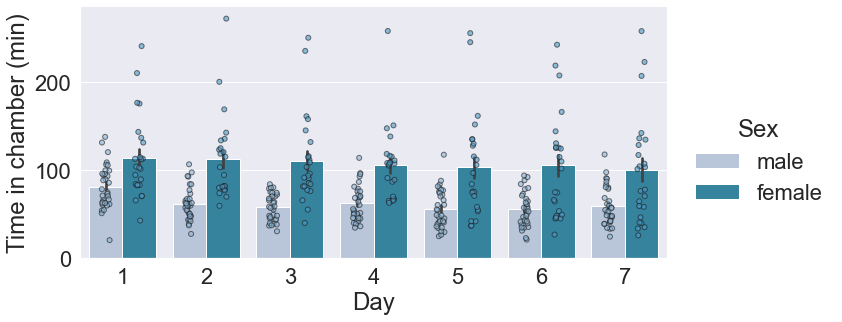

In [34]:
g= sns.catplot(x='ld_day', y='Time in chamber (min)', data=data_RFID_total_daily,  kind='bar', height=5, aspect=2,
            ci=68, hue='Sex', palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'ld_day', 'Time in chamber (min)', 'Sex',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)

plt.xlabel('Day')
plt.show()

In [35]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='Sex', subject='IdRFID', data=data_RFID_total_daily)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='Sex',
                              subject='IdRFID', data=data_RFID_total_daily, padjust='bonf')
pg.print_table(posthocs)


ANOVA SUMMARY

Source               SS    DF1    DF2          MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ----------  -----  -----  ----------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
Sex          195667.601      1     54  195667.601  26.265    0.000      nan      0.327  nan           nan        nan        nan
ld_day        15246.728      6    324    2541.121   5.702    0.000        0.001  0.096    0.460         0.000      0.045      0.000
Interaction    3937.756      6    324     656.293   1.473    0.187      nan      0.027  nan           nan        nan        nan


POST HOC TESTS

Contrast      ld_day    A     B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust        BF10    hedges
------------  --------  ----  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  --------  --------
ld_day        -         1     2     

## hourly total with combined substances

### event duration proportion

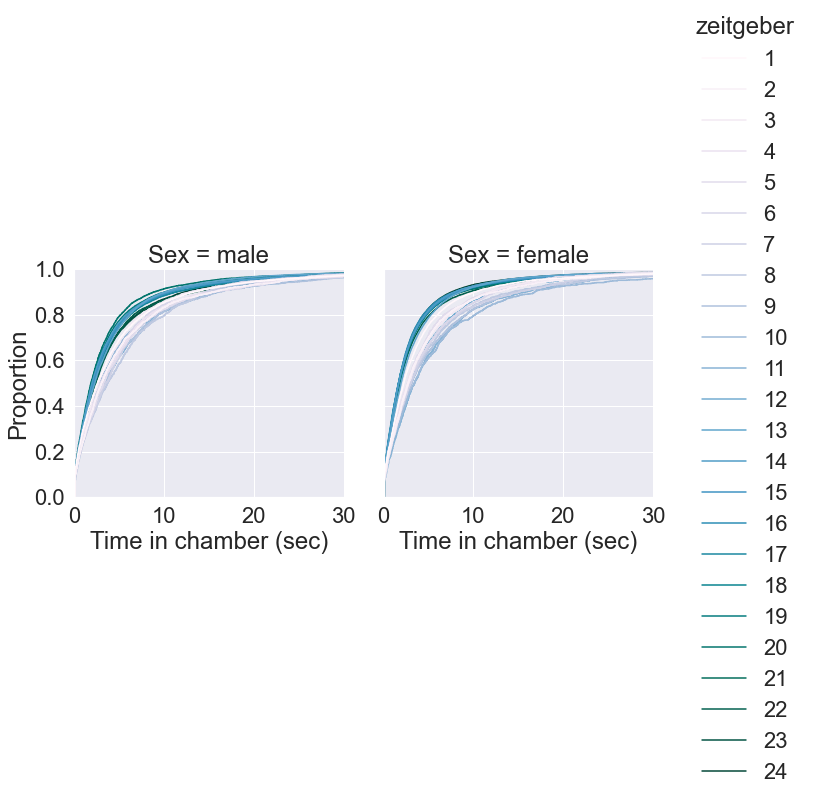

In [36]:
g=sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='zeitgeber', col='Sex', palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [37]:
data_RFID_total_hourly = data_RFID.groupby(['IdRFID', 'Sex', 'zeitgeber', 
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_hourly['Time in chamber (min)'] = data_RFID_total_hourly['eventDuration']/60

data_RFID_total_hourly.head()

,IdRFID,Sex,zeitgeber,eventDuration,Time in chamber (min)
0,041ABFE4E6,male,1,1026.680,17.111333
1,041ABFE4E6,male,2,638.714,10.645233
2,041ABFE4E6,male,3,238.381,3.973017
3,041ABFE4E6,male,4,113.320,1.888667
4,041ABFE4E6,male,5,309.242,5.154033


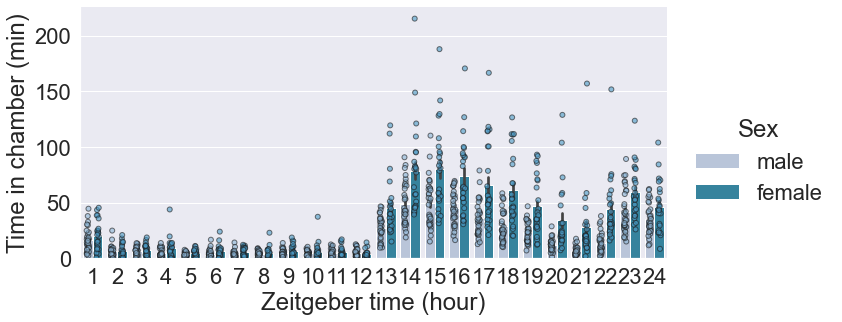

In [38]:
g= sns.catplot(x='zeitgeber', y='Time in chamber (min)', data=data_RFID_total_hourly,  kind='bar', height=5, aspect=2,
            ci=68, hue='Sex', palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'zeitgeber', 'Time in chamber (min)', 'Sex',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1,
      )

plt.xlabel('Zeitgeber time (hour)')
plt.show()

In [39]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='zeitgeber', between='Sex', subject='IdRFID', data=data_RFID_total_hourly)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='zeitgeber', between='Sex',
                              subject='IdRFID', data=data_RFID_total_hourly, padjust='bonf')
pg.print_table(posthocs)


ANOVA SUMMARY

Source               SS    DF1    DF2         MS        F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ----------  -----  -----  ---------  -------  -------  -----------  -----  -------  ------------  ---------  ---------
Sex           57069.717      1     54  57069.717   26.265    0.000      nan      0.327  nan           nan        nan        nan
zeitgeber    564313.439     23   1242  24535.367  121.178    0.000        0.000  0.692    0.119         0.000      0.000      0.000
Interaction   50635.805     23   1242   2201.557   10.873    0.000      nan      0.168  nan           nan        nan        nan


POST HOC TESTS

Contrast         zeitgeber    A     B       Paired    Parametric          T     dof  Tail         p-unc    p-corr  p-adjust                       BF10    hedges
---------------  -----------  ----  ------  --------  ------------  -------  ------  ---------  -------  --------  ----------  -----------------------  -

## daily and hourly combined substances heatmap

In [40]:
data_RFID_total_hour_day = data_RFID.groupby(['IdRFID', 'Sex', 'zeitgeber', 'ld_day',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_hour_day['Time in chamber (min)'] = data_RFID_total_hour_day['eventDuration']/60

data_RFID_total_hour_day.head()

,IdRFID,Sex,zeitgeber,ld_day,eventDuration,Time in chamber (min)
0,041ABFE4E6,male,1,1,81.002,1.350033
1,041ABFE4E6,male,1,2,399.488,6.658133
2,041ABFE4E6,male,1,3,0.000,0.000000
3,041ABFE4E6,male,1,4,106.825,1.780417
4,041ABFE4E6,male,1,5,69.442,1.157367


### event duration

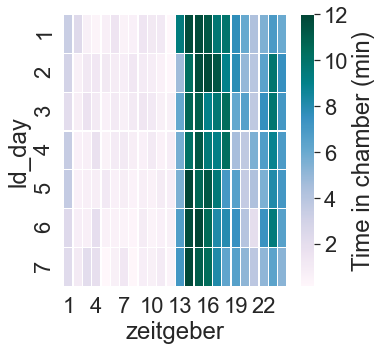

In [41]:
d = data_RFID_total_hour_day[data_RFID_total_hour_day['Sex']=='female']
groupby = d.groupby(['ld_day', 'zeitgeber'])['Time in chamber (min)'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "Time in chamber (min)")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=12,
                     cbar_kws={'label': 'Time in chamber (min)'})

#plt.xlabel('Bottle')
plt.show()

## total with separate substances 

### event duration proportion

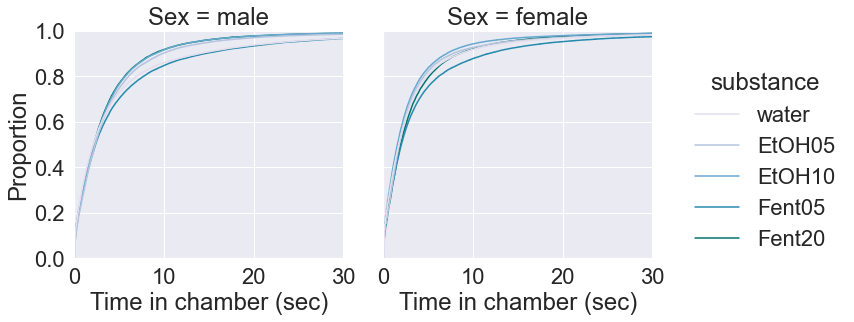

In [42]:
order=['water', 'EtOH05', 'EtOH10', 'Fent05', 'Fent20']

g=sns.displot(data=data_RFID_start, x="eventDuration", kind='ecdf', hue='substance', col='Sex', palette='PuBuGn',
             hue_order=order)
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [43]:
order=['water', 'EtOH05', 'EtOH10', 'Fent05', 'Fent20']
data_RFID_total_sub = data_RFID.groupby(['IdRFID', 'Sex', 'substance',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_sub['Time in chamber (min)'] = data_RFID_total_sub['eventDuration']/60

data_RFID_total_sub.head()

,IdRFID,Sex,substance,eventDuration,Time in chamber (min)
0,041ABFE4E6,male,EtOH05,2413.942,40.232367
1,041ABFE4E6,male,EtOH10,3182.143,53.035717
2,041ABFE4E6,male,Fent05,2016.976,33.616267
3,041ABFE4E6,male,Fent20,1811.555,30.192583
4,041ABFE4E6,male,water,21709.277,361.821283


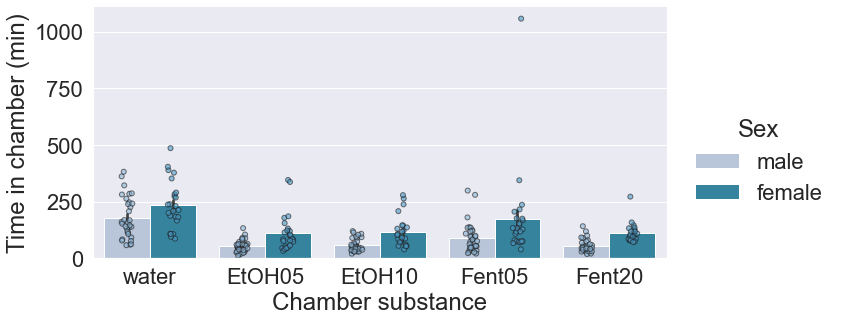

In [44]:
g= sns.catplot(x='substance', y='Time in chamber (min)', data=data_RFID_total_sub,  kind='bar', height=5, aspect=2,
            ci=68, hue='Sex', order=order, palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'substance', 'Time in chamber (min)', 'Sex',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1,
      order=order)

plt.xlabel('Chamber substance')
plt.show()

In [45]:
dv = 'Time in chamber (min)'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='substance', between='Sex', subject='IdRFID', data=data_RFID_total_sub)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='substance', between='Sex',
                              subject='IdRFID', data=data_RFID_total_sub, padjust='bonf')
pg.print_table(posthocs)


ANOVA SUMMARY

Source               SS    DF1    DF2          MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ----------  -----  -----  ----------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
Sex          273934.642      1     54  273934.642  26.265    0.000      nan      0.327  nan           nan        nan        nan
substance    639832.559      4    216  159958.140  24.996    0.000        0.000  0.316    0.528         0.000      0.099      0.000
Interaction    6524.950      4    216    1631.237   0.255    0.906      nan      0.005  nan           nan        nan        nan


POST HOC TESTS

Contrast         substance    A       B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust               BF10    hedges
---------------  -----------  ------  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ---------------  --------
substa

## daily with separate substances 

### event duration proportion

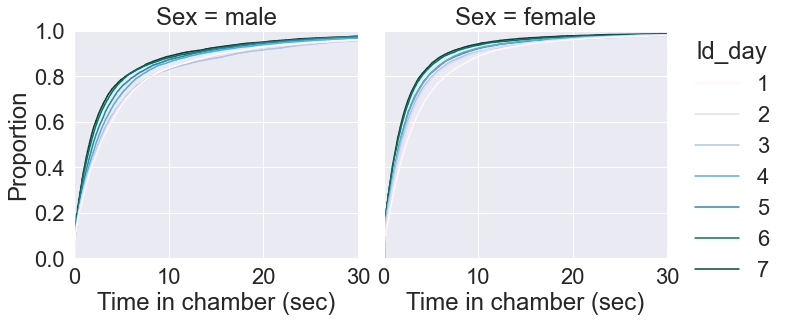

In [46]:
d = data_RFID_start[data_RFID_start['substance']=='water']

g=sns.displot(data=d, x="eventDuration", kind='ecdf', hue='ld_day', col='Sex', palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [47]:
data_RFID_sub_daily = data_RFID.groupby(['IdRFID', 'Sex', 'ld_day', 'substance'
                                   ])['eventDuration'].sum().reset_index()

data_RFID_sub_daily['Time in chamber (min)'] = data_RFID_sub_daily['eventDuration']/60

data_RFID_sub_daily.head()

,IdRFID,Sex,ld_day,substance,eventDuration,Time in chamber (min)
0,041ABFE4E6,male,1,EtOH05,1158.326,19.305433
1,041ABFE4E6,male,1,EtOH10,946.228,15.770467
2,041ABFE4E6,male,1,Fent05,870.990,14.516500
3,041ABFE4E6,male,1,Fent20,572.351,9.539183
4,041ABFE4E6,male,1,water,2998.588,49.976467


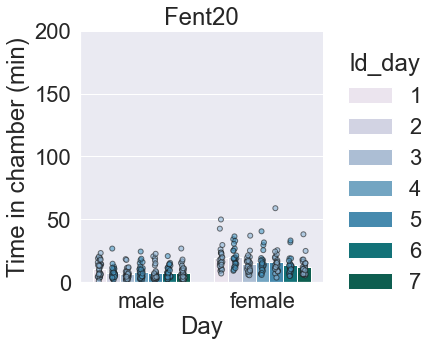

In [60]:
sub = 'Fent20'
d = data_RFID_sub_daily[data_RFID_sub_daily['substance']==sub]

g= sns.catplot(x='Sex', y='Time in chamber (min)', data=d,  kind='bar', height=5, aspect=1,
            ci=68, hue='ld_day', palette='PuBuGn', )

# map data to stripplot
g.map(sns.stripplot, 'Sex', 'Time in chamber (min)', 'ld_day', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1 )

plt.ylim(0,200)
plt.title(sub)
plt.xlabel('Day')
plt.show()

In [61]:
dv = 'Time in chamber (min)'

d = data_RFID_sub_daily[data_RFID_sub_daily['substance']==sub]

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='Sex', subject='IdRFID', data=d)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='Sex',
                              subject='IdRFID', data=d, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source             SS    DF1    DF2        MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  --------  -----  -----  --------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
Sex          6401.127      1     54  6401.127  37.783    0.000      nan      0.412  nan           nan        nan        nan
ld_day        936.591      6    324   156.099   6.203    0.000        0.000  0.103    0.657         0.000      0.137      0.000
Interaction   533.198      6    324    88.866   3.531    0.002      nan      0.061  nan           nan        nan        nan


POST HOC TESTS

Contrast      ld_day    A     B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust           BF10    hedges
------------  --------  ----  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  -----------  --------
ld_day        -         1     2       True      Tr

## light dark with separate substances 

### event duration proportion

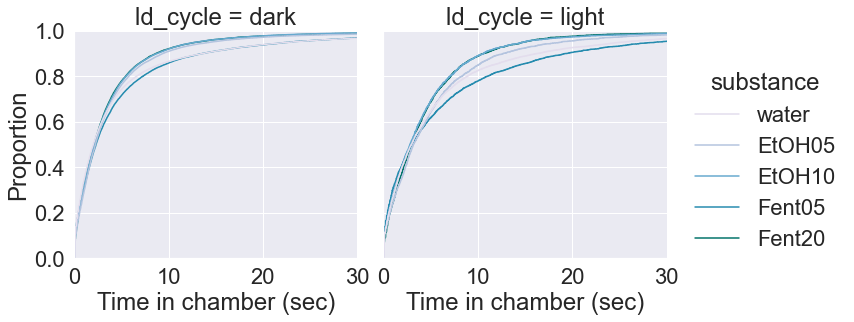

In [62]:
d = data_RFID_start[data_RFID_start['Sex']=='male']

g=sns.displot(data=d, x="eventDuration", kind='ecdf', hue='substance', col='ld_cycle', palette='PuBuGn',
              hue_order=order)
#plt.ylim(0,2000)
plt.xlim(0,30)

g.set_axis_labels('Time in chamber (sec)')
plt.show()

### total event duration sum

In [63]:
data_RFID_sub_ld = data_RFID.groupby(['IdRFID', 'Sex', 'ld_cycle', 'substance',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_sub_ld['Time in chamber (min)'] = data_RFID_sub_ld['eventDuration']/60

data_RFID_sub_ld.head()

,IdRFID,Sex,ld_cycle,substance,eventDuration,Time in chamber (min)
0,041ABFE4E6,male,dark,EtOH05,2142.355,35.705917
1,041ABFE4E6,male,dark,EtOH10,2725.643,45.427383
2,041ABFE4E6,male,dark,Fent05,1712.108,28.535133
3,041ABFE4E6,male,dark,Fent20,1592.380,26.539667
4,041ABFE4E6,male,dark,water,18601.822,310.030367


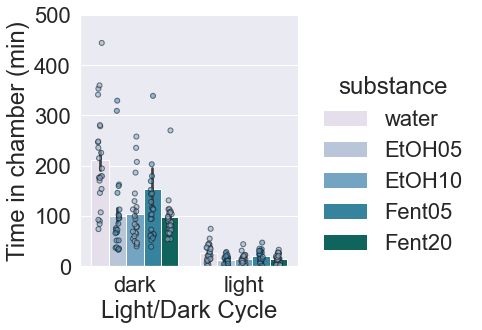

In [64]:
d = data_RFID_sub_ld[data_RFID_sub_ld['Sex']=='female']

g= sns.catplot(x='ld_cycle', y='Time in chamber (min)', data=d,  kind='bar', height=5, aspect=1,
            ci=68, hue='substance', palette='PuBuGn', hue_order=order)

# map data to stripplot
g.map(sns.stripplot, 'ld_cycle', 'Time in chamber (min)', 'substance', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1 , hue_order=order)

plt.ylim(0,500)
plt.xlabel('Light/Dark Cycle')
plt.show()

In [65]:
data_RFID_sub_ld.set_index(['IdRFID', 'Sex', 'ld_cycle', 'substance'])['Time in chamber (min)'].unstack(-1).to_csv('data_RFID_sub_ld.csv')

## daily and hourly total with separate substance heatmap

### event duration

In [66]:
data_RFID_total_sub_day_hour = data_RFID.groupby(['IdRFID', 'Sex', 'substance', 'ld_day', 'zeitgeber',
                                   ])['eventDuration'].sum().reset_index()

data_RFID_total_sub_day_hour['Time in chamber (min)'] = data_RFID_total_sub_day_hour['eventDuration']/60

data_RFID_total_sub_day_hour.head()

,IdRFID,Sex,substance,ld_day,zeitgeber,eventDuration,Time in chamber (min)
0,041ABFE4E6,male,EtOH05,1,1,9.074,0.151233
1,041ABFE4E6,male,EtOH05,1,2,0.000,0.000000
2,041ABFE4E6,male,EtOH05,1,3,5.823,0.097050
3,041ABFE4E6,male,EtOH05,1,4,0.000,0.000000
4,041ABFE4E6,male,EtOH05,1,5,0.344,0.005733


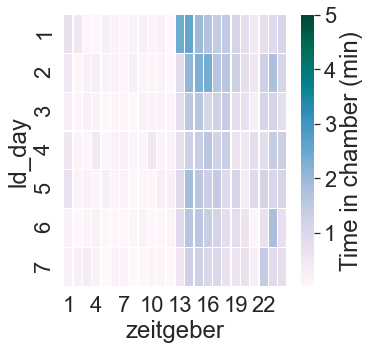

In [67]:
d = data_RFID_total_sub_day_hour[data_RFID_total_sub_day_hour['Sex']=='female']
d = d[d['substance']=='Fent20']
groupby = d.groupby(['ld_day', 'zeitgeber'])['Time in chamber (min)'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "Time in chamber (min)")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=5,
                     cbar_kws={'label': 'Time in chamber (min)'})

#plt.xlabel('Bottle')
plt.show()

## ID heatmap

In [68]:
data_RFID_total_sub['Id'] = data_RFID_total_sub['Sex'] + '_' + data_RFID_total_sub['IdRFID'].astype('str')
data_RFID_total_sub.head()

,IdRFID,Sex,substance,eventDuration,Time in chamber (min),Id
0,041ABFE4E6,male,EtOH05,2413.942,40.232367,male_041ABFE4E6
1,041ABFE4E6,male,EtOH10,3182.143,53.035717,male_041ABFE4E6
2,041ABFE4E6,male,Fent05,2016.976,33.616267,male_041ABFE4E6
3,041ABFE4E6,male,Fent20,1811.555,30.192583,male_041ABFE4E6
4,041ABFE4E6,male,water,21709.277,361.821283,male_041ABFE4E6


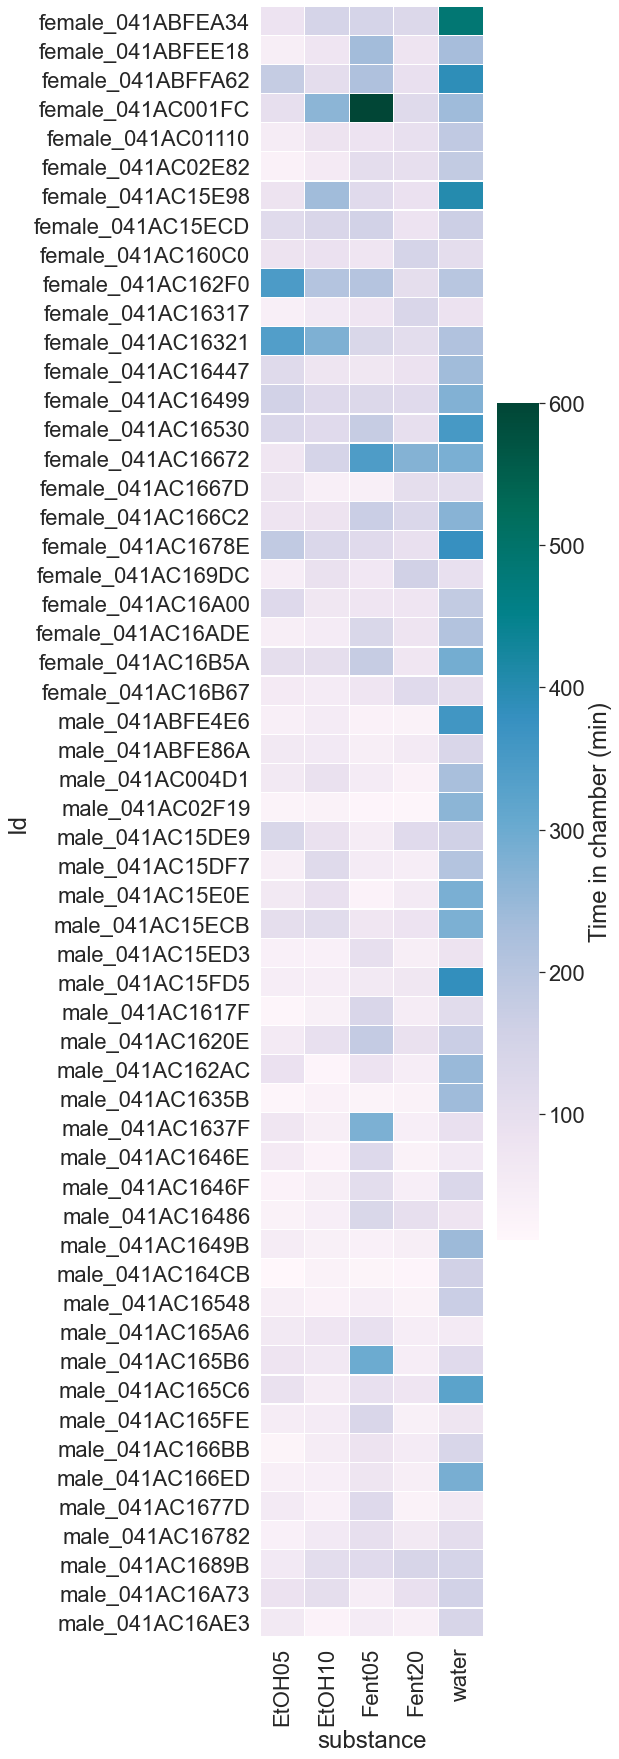

In [69]:
sns.set(font_scale=2)
groupby = data_RFID_total_sub.pivot('Id', 'substance', "Time in chamber (min)")
plt.figure(figsize=(5,30))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=600,
                     cbar_kws={'label': 'Time in chamber (min)'})


#plt.xlabel('Bottle')
plt.show()

## Raster

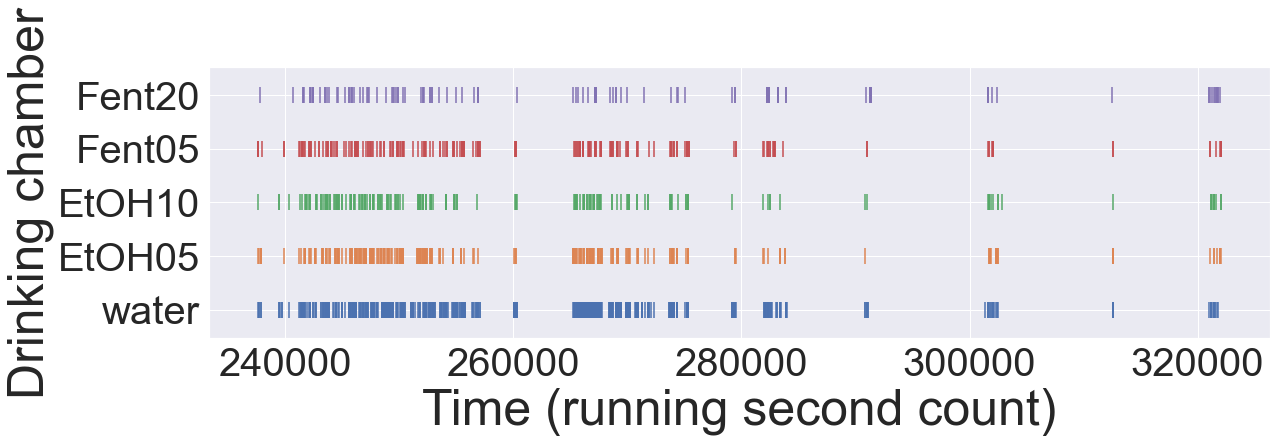

In [70]:
mice = ['041AC1620E', '041AC15DE9', '041AC16321', '041AC16A00', ]
data_idivid = data_RFID_start[data_RFID_start['IdRFID']==mice[3]]
data_idivid = data_idivid[data_idivid['ld_day']==4]
colorCodes = ['C{}'.format(i) for i in range(5)]

param = 'RFID_sec_count_running'
data_1 = data_idivid[data_idivid['substance'] == 'water'][param].values
data_2 = data_idivid[data_idivid['substance'] == 'EtOH05'][param].values
data_3 = data_idivid[data_idivid['substance'] == 'EtOH10'][param].values
data_4 = data_idivid[data_idivid['substance'] == 'Fent05'][param].values
data_5 = data_idivid[data_idivid['substance'] == 'Fent20'][param].values

data_array = np.array([data_1, data_2, data_3, data_4, data_5])

# Draw a spike raster plot
plt.figure(figsize=(19,5))
params = {'axes.labelsize': 75,
          'axes.titlesize': 75}
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
plt.rcParams.update(params)
plt.yticks([0,1,2,3,4], 
           ['water', 'EtOH05', 'EtOH10', 'Fent05', 'Fent20'])
plt.eventplot(data_array, color=colorCodes, linelengths = 0.3) 
plt.xlabel('Time (running second count)', fontsize=50)
plt.ylabel('Drinking chamber', fontsize=50)

plt.show()

# Drinking data

In [71]:
sns.set_context("poster")
sns.set_style("ticks")
sns.set(font_scale=2)

## total with combined substances

In [72]:
data_final_clean_3s = data_final
data_final_clean_3s.head()

,zeitgeber,ld_day,ddd,ld_cycle,substance,IdRFID,Sex,intake_ml_kg,zeit_quart
56,1,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0
126,2,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0
63,3,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0
98,4,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0
140,5,1,0,light,EtOH05,041ABFE4E6,male,0.0,1.0


### total intake sum min

In [73]:
data_VDM_total_min = data_VDM_start.groupby(['IdRFID', 'Sex', 'VDM_min_count_running',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_min.head()

,IdRFID,Sex,VDM_min_count_running,intake_ml_kg
0,041ABFE4E6,male,-218,2.491349
1,041ABFE4E6,male,-214,3.321799
2,041ABFE4E6,male,-207,2.491349
3,041ABFE4E6,male,-169,0.830450
4,041ABFE4E6,male,-143,3.321799


(0.0, 10.0)

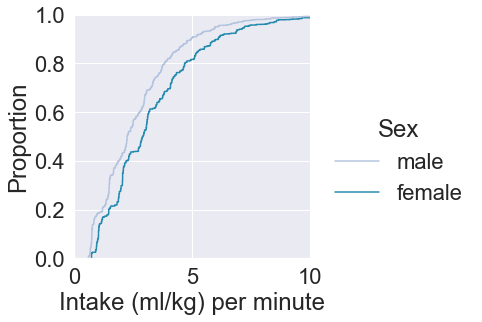

In [74]:
sns.displot(data=data_VDM_total_min, x="intake_ml_kg", kind='ecdf', hue='Sex',
           palette='PuBuGn')

plt.xlabel('Intake (ml/kg) per minute')

plt.xlim(0,10)

### total intake sum

In [75]:
data_VDM_total = data_final_clean_3s.groupby(['IdRFID', 'Sex', 
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total.head()

,IdRFID,Sex,intake_ml_kg
0,041ABFE4E6,male,1315.086505
1,041ABFE86A,male,540.588235
2,041ABFEA34,female,726.562500
3,041ABFEE18,female,792.178218
4,041ABFFA62,female,989.333333


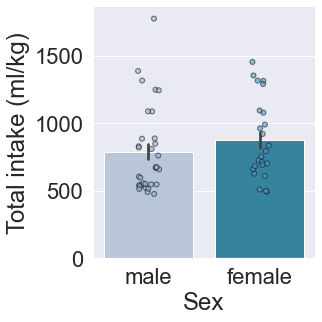

Ttest_indResult(statistic=1.080622096069826, pvalue=0.2846679186225046)

In [76]:
g = sns.catplot(x='Sex', y='intake_ml_kg', data=data_VDM_total,  kind='bar', height=5, aspect=1,
            ci=68, palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'Sex', 'intake_ml_kg', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)
plt.ylabel('Total intake (ml/kg)')
plt.show()

male = data_VDM_total[data_VDM_total['Sex']=='male']['intake_ml_kg']
female = data_VDM_total[data_VDM_total['Sex']=='female']['intake_ml_kg']
stats.ttest_ind(female, male)

## light dark with combined substances

### total intake sum min

In [77]:
data_VDM_total_ld_min = data_VDM_start.groupby(['IdRFID', 'Sex', 'VDM_min_count_running', 'ld_cycle',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_ld_min.head()

,IdRFID,Sex,VDM_min_count_running,ld_cycle,intake_ml_kg
0,041ABFE4E6,male,-218,dark,2.491349
1,041ABFE4E6,male,-214,dark,3.321799
2,041ABFE4E6,male,-207,dark,2.491349
3,041ABFE4E6,male,-169,dark,0.830450
4,041ABFE4E6,male,-143,dark,3.321799


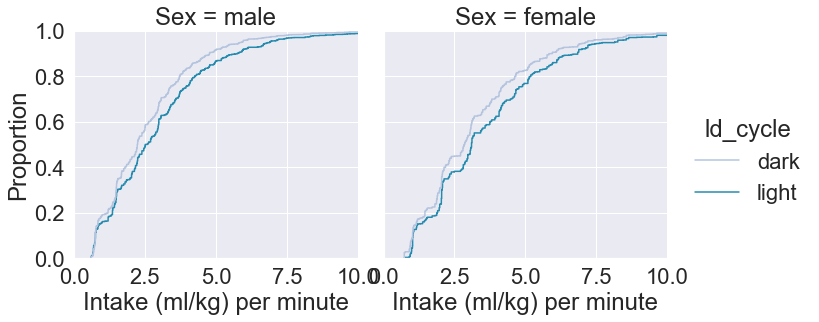

In [78]:
g=sns.displot(data=data_VDM_total_ld_min, x="intake_ml_kg", kind='ecdf', hue='ld_cycle', col='Sex', palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,10)

g.set_axis_labels('Intake (ml/kg) per minute')
plt.show()

### total intake sum

In [79]:
data_VDM_total_ld = data_final_clean_3s.groupby(['IdRFID', 'Sex', 'ld_cycle',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_ld.head()

,IdRFID,Sex,ld_cycle,intake_ml_kg
0,041ABFE4E6,male,dark,970.242215
1,041ABFE4E6,male,light,344.844291
2,041ABFE86A,male,dark,451.544118
3,041ABFE86A,male,light,89.044118
4,041ABFEA34,female,dark,592.500000


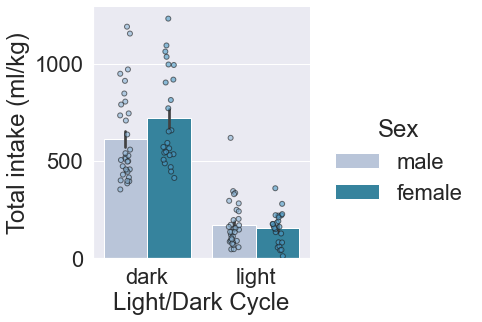

In [80]:
g= sns.catplot(x='ld_cycle', y='intake_ml_kg', data=data_VDM_total_ld,  kind='bar', height=5, aspect=1,
            ci=68, hue='Sex', palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'ld_cycle', 'intake_ml_kg', 'Sex',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)


plt.xlabel('Light/Dark Cycle')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [81]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_cycle', between='Sex', subject='IdRFID', data=data_VDM_total_ld)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_cycle', between='Sex',
                              subject='IdRFID', data=data_VDM_total_ld, padjust='holm')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                SS    DF1    DF2           MS        F    p-unc    np2      eps
-----------  -----------  -----  -----  -----------  -------  -------  -----  -------
Sex            56037.818      1     54    56037.818    1.168    0.285  0.021  nan
ld_cycle     6863250.025      1     54  6863250.025  356.726    0.000  0.869    1.000
Interaction   107701.431      1     54   107701.431    5.598    0.022  0.094  nan


POST HOC TESTS

Contrast        ld_cycle    A     B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust                          BF10    hedges
--------------  ----------  ----  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  --------------------------  --------
ld_cycle        -           dark  light   True      True          18.144  55.000  two-sided    0.000   nan      nan         5244000000000000000000.000     2.648
Sex             -           male  female  False     True     

## daily total with combined substances

### total intake sum min

In [82]:
data_VDM_total_daily_min = data_VDM_start.groupby(['IdRFID', 'Sex', 'VDM_min_count_running', 'ld_day',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_daily_min.head()

,IdRFID,Sex,VDM_min_count_running,ld_day,intake_ml_kg
0,041ABFE4E6,male,-218,1,2.491349
1,041ABFE4E6,male,-214,1,3.321799
2,041ABFE4E6,male,-207,1,2.491349
3,041ABFE4E6,male,-169,1,0.830450
4,041ABFE4E6,male,-143,1,3.321799


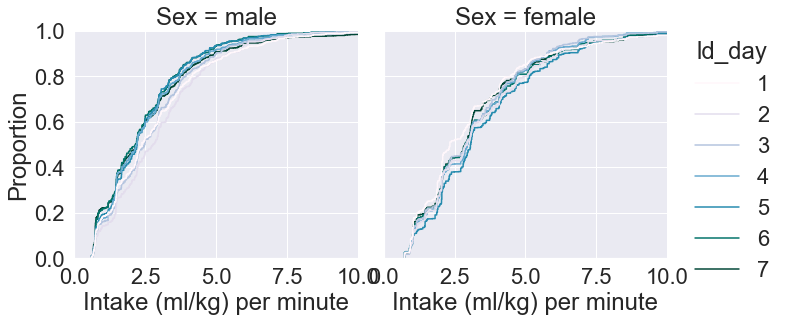

In [83]:
g=sns.displot(data=data_VDM_total_daily_min, x="intake_ml_kg", kind='ecdf', hue='ld_day', col='Sex', palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,10)

g.set_axis_labels('Intake (ml/kg) per minute')
plt.show()

### total intake sum

In [84]:
data_VDM_total_daily = data_final_clean_3s.groupby(['IdRFID', 'Sex', 'ld_day',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_daily.head()

,IdRFID,Sex,ld_day,intake_ml_kg
0,041ABFE4E6,male,1,123.114187
1,041ABFE4E6,male,2,216.055363
2,041ABFE4E6,male,3,213.425606
3,041ABFE4E6,male,4,176.055363
4,041ABFE4E6,male,5,179.515571


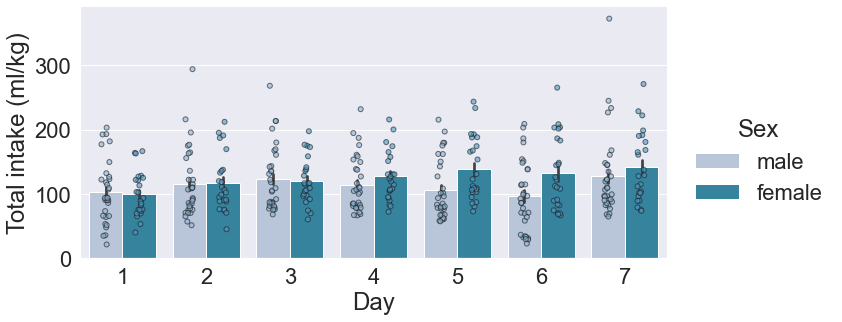

In [85]:
g= sns.catplot(x='ld_day', y='intake_ml_kg', data=data_VDM_total_daily,  kind='bar', height=5, aspect=2,
            ci=68, hue='Sex', palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'ld_day', 'intake_ml_kg', 'Sex',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)

plt.xlabel('Day')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [86]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='Sex', subject='IdRFID', data=data_VDM_total_daily)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='Sex',
                              subject='IdRFID', data=data_VDM_total_daily, padjust='holm')
pg.print_table(posthocs)


ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ---------  -----  -----  ---------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
Sex          16010.805      1     54  16010.805  1.168    0.285      nan      0.021  nan           nan        nan        nan
ld_day       33311.587      6    324   5551.931  9.829    0.000        0.000  0.154    0.473         0.000      0.035      0.000
Interaction  21543.132      6    324   3590.522  6.357    0.000      nan      0.105  nan           nan        nan        nan


POST HOC TESTS

Contrast      ld_day    A     B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust        BF10    hedges
------------  --------  ----  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  --------  --------
ld_day        -         1     2       True      Tru

## hourly total with combined substances

### total intake sum

In [87]:
data_VDM_total_zeit = data_final_clean_3s.groupby(['IdRFID', 'Sex', 'zeitgeber',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_zeit.head()

,IdRFID,Sex,zeitgeber,intake_ml_kg
0,041ABFE4E6,male,1,59.792388
1,041ABFE4E6,male,2,41.522491
2,041ABFE4E6,male,3,34.878893
3,041ABFE4E6,male,4,9.134948
4,041ABFE4E6,male,5,58.131488


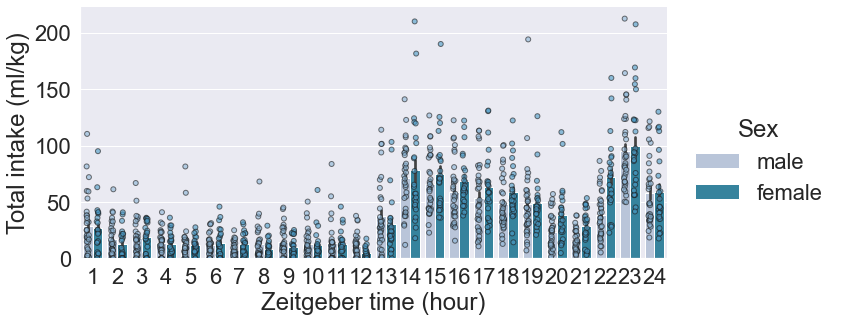

In [88]:
g= sns.catplot(x='zeitgeber', y='intake_ml_kg', data=data_VDM_total_zeit,  kind='bar', height=5, aspect=2,
            ci=68, hue='Sex', palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'zeitgeber', 'intake_ml_kg', 'Sex',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)

plt.xlabel('Zeitgeber time (hour)')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [89]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='zeitgeber', between='Sex', subject='IdRFID', data=data_VDM_total_zeit)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='zeitgeber', between='Sex',
                              subject='IdRFID', data=data_VDM_total_zeit, padjust='bonf')
pg.print_table(posthocs)


ANOVA SUMMARY

Source               SS    DF1    DF2         MS        F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ----------  -----  -----  ---------  -------  -------  -----------  -----  -------  ------------  ---------  ---------
Sex            4669.818      1     54   4669.818    1.168    0.285      nan      0.021  nan           nan        nan        nan
zeitgeber    850274.321     23   1242  36968.449  101.183    0.000        0.000  0.652    0.292         0.000      0.000      0.000
Interaction   25606.176     23   1242   1113.312    3.047    0.000      nan      0.053  nan           nan        nan        nan


POST HOC TESTS

Contrast         zeitgeber    A     B       Paired    Parametric          T     dof  Tail         p-unc    p-corr  p-adjust                         BF10    hedges
---------------  -----------  ----  ------  --------  ------------  -------  ------  ---------  -------  --------  ----------  ------------------------

## daily and hourly combines substances heatmap

### total drinking

In [90]:
data_VDM_total_hour_day = data_final_clean_3s.groupby(['IdRFID', 'Sex', 'zeitgeber', 'ld_day',
                                   ])['intake_ml_kg'].sum().reset_index()

data_VDM_total_hour_day.head()

,IdRFID,Sex,zeitgeber,ld_day,intake_ml_kg
0,041ABFE4E6,male,1,1,7.474048
1,041ABFE4E6,male,1,2,22.422145
2,041ABFE4E6,male,1,3,0.000000
3,041ABFE4E6,male,1,4,10.795848
4,041ABFE4E6,male,1,5,9.134948


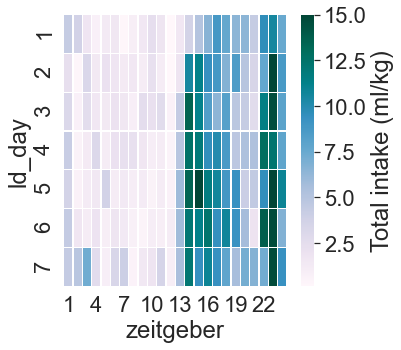

In [91]:
d = data_VDM_total_hour_day[data_VDM_total_hour_day['Sex']=='female']
groupby = d.groupby(['ld_day', 'zeitgeber'])['intake_ml_kg'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "intake_ml_kg")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=15,
                     cbar_kws={'label': 'Total intake (ml/kg)'})

#plt.xlabel('Bottle')
plt.show()

## total with separate substances

### total intake sum min

In [92]:
data_VDM_total_sub_min = data_VDM_start.groupby(['IdRFID', 'Sex', 'VDM_min_count_running', 'substance',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub_min.head()

,IdRFID,Sex,VDM_min_count_running,substance,intake_ml_kg
0,041ABFE4E6,male,-218,water,2.491349
1,041ABFE4E6,male,-214,water,3.321799
2,041ABFE4E6,male,-207,water,2.491349
3,041ABFE4E6,male,-169,water,0.830450
4,041ABFE4E6,male,-143,water,3.321799


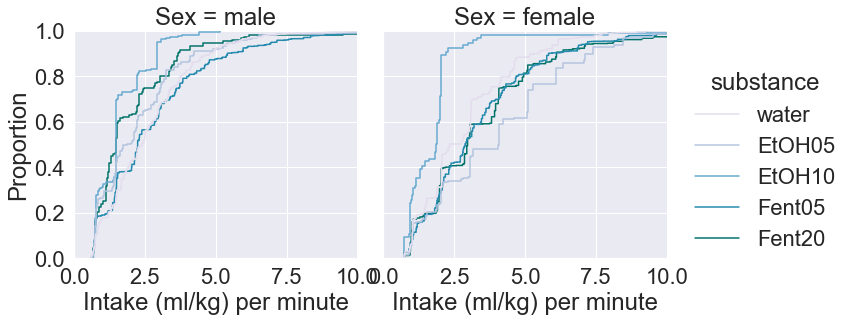

In [93]:
g=sns.displot(data=data_VDM_total_sub_min, x="intake_ml_kg", kind='ecdf', hue='substance', col='Sex', 
              hue_order=order, palette='PuBuGn')
#plt.ylim(0,2000)
plt.xlim(0,10)

g.set_axis_labels('Intake (ml/kg) per minute')
plt.show()

### total intake sum

In [94]:
data_VDM_total_sub = data_final_clean_3s.groupby(['IdRFID', 'Sex', 'substance',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub.tail()

,IdRFID,Sex,substance,intake_ml_kg
275,041AC16B67,female,EtOH05,5.943396
276,041AC16B67,female,EtOH10,31.698113
277,041AC16B67,female,Fent05,229.811321
278,041AC16B67,female,Fent20,407.122642
279,041AC16B67,female,water,6.933962


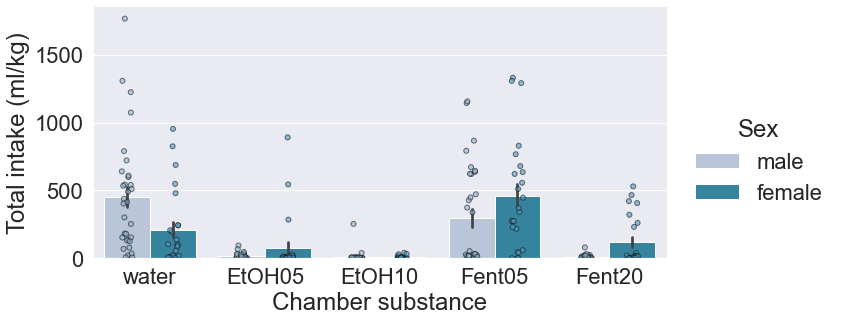

In [95]:
g= sns.catplot(x='substance', y='intake_ml_kg', data=data_VDM_total_sub,  kind='bar', height=5, aspect=2,
            ci=68, hue='Sex', order=order, palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'substance', 'intake_ml_kg', 'Sex',
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1,
      order=order,)

plt.xlabel('Chamber substance')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [96]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='substance', between='Sex', subject='IdRFID', data=data_VDM_total_sub)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='substance', between='Sex',
                              subject='IdRFID', data=data_VDM_total_sub, padjust='bonf')
pg.print_table(posthocs)


ANOVA SUMMARY

Source                SS    DF1    DF2           MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -----------  -----  -----  -----------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
Sex            22415.127      1     54    22415.127   1.168    0.285      nan      0.021  nan           nan        nan        nan
substance    7050249.528      4    216  1762562.382  23.651    0.000        0.000  0.305    0.422         0.000      0.021      0.000
Interaction  1357483.465      4    216   339370.866   4.554    0.001      nan      0.078  nan           nan        nan        nan


POST HOC TESTS

Contrast         substance    A       B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust           BF10    hedges
---------------  -----------  ------  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  -----------  --------
subs

## light dark with separate substances 

### total intake

In [97]:
data_VDM_total_sub_ld = data_final_clean_3s.groupby(['IdRFID', 'Sex', 'ld_cycle', 'substance',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub_ld.head()

,IdRFID,Sex,ld_cycle,substance,intake_ml_kg
0,041ABFE4E6,male,dark,EtOH05,0.761246
1,041ABFE4E6,male,dark,EtOH10,1.660900
2,041ABFE4E6,male,dark,Fent05,2.802768
3,041ABFE4E6,male,dark,Fent20,0.000000
4,041ABFE4E6,male,dark,water,965.017301


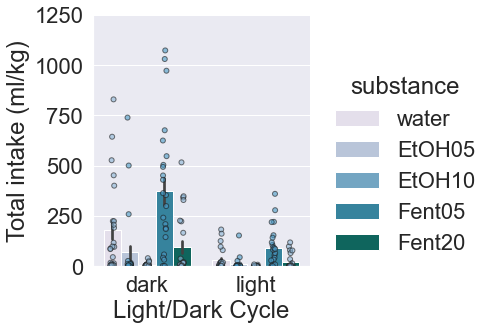

In [98]:
d = data_VDM_total_sub_ld[data_VDM_total_sub_ld['Sex']=='female']

g= sns.catplot(x='ld_cycle', y='intake_ml_kg', data=d,  kind='bar', height=5, aspect=1,
            ci=68, hue='substance', palette='PuBuGn', hue_order=order)

# map data to stripplot
g.map(sns.stripplot, 'ld_cycle', 'intake_ml_kg', 'substance', hue_order=order,
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)

plt.ylim(0,1250)
plt.xlabel('Light/Dark Cycle')
plt.ylabel('Total intake (ml/kg)')
plt.show()

In [99]:
data_VDM_total_sub_ld.set_index(['IdRFID', 'Sex', 'ld_cycle', 'substance'])['intake_ml_kg'].unstack(-1).to_csv('data_VDM_total_sub_ld.csv')

## daily with separate substances 

In [100]:
data_VDM_total_sub_day = data_final_clean_3s.groupby(['IdRFID', 'Sex', 'ld_day', 'substance',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub_day.head()

,IdRFID,Sex,ld_day,substance,intake_ml_kg
0,041ABFE4E6,male,1,EtOH05,0.000000
1,041ABFE4E6,male,1,EtOH10,0.000000
2,041ABFE4E6,male,1,Fent05,1.868512
3,041ABFE4E6,male,1,Fent20,0.000000
4,041ABFE4E6,male,1,water,121.245675


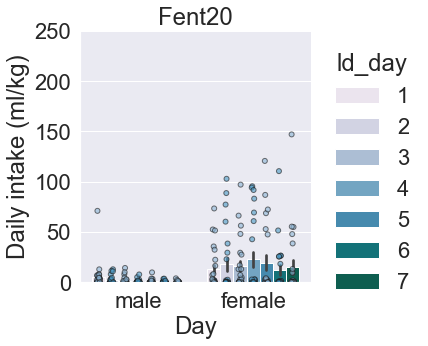

In [111]:
sub = 'Fent20'
d = data_VDM_total_sub_day[data_VDM_total_sub_day['substance']==sub]

g= sns.catplot(x='Sex', y='intake_ml_kg', data=d,  kind='bar', height=5, aspect=1,
            ci=68, hue='ld_day', palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'Sex', 'intake_ml_kg', 'ld_day', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)

plt.ylim(0,250)
plt.title(sub)
plt.xlabel('Day')
plt.ylabel('Daily intake (ml/kg)')
plt.show()

In [112]:
dv = 'intake_ml_kg'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='Sex', subject='IdRFID', data=d)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='Sex',
                              subject='IdRFID', data=d, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source              SS    DF1    DF2         MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ---------  -----  -----  ---------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
Sex          22008.810      1     54  22008.810  11.095    0.002      nan      0.170  nan           nan        nan        nan
ld_day         830.316      6    324    138.386   0.951    0.459        0.422  0.017    0.475         0.000      0.005      0.000
Interaction   1725.636      6    324    287.606   1.976    0.069      nan      0.035  nan           nan        nan        nan


POST HOC TESTS

Contrast      ld_day    A     B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
------------  --------  ----  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ------  --------
ld_day        -         1     2       True      Tr

## daily and hourly total with separate substances heatmap

### total intake

In [113]:
data_VDM_total_sub_day_hour = data_final_clean_3s.groupby(['IdRFID', 'Sex', 'substance', 'ld_day', 'zeitgeber',
                                   ])[['intake_ml_kg']].sum().reset_index()

data_VDM_total_sub_day_hour.head()

,IdRFID,Sex,substance,ld_day,zeitgeber,intake_ml_kg
0,041ABFE4E6,male,EtOH05,1,1,0.0
1,041ABFE4E6,male,EtOH05,1,2,0.0
2,041ABFE4E6,male,EtOH05,1,3,0.0
3,041ABFE4E6,male,EtOH05,1,4,0.0
4,041ABFE4E6,male,EtOH05,1,5,0.0


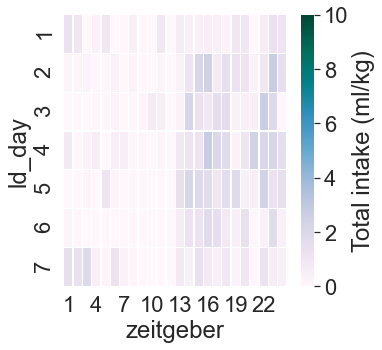

In [114]:
d = data_VDM_total_sub_day_hour[data_VDM_total_sub_day_hour['Sex']=='female']
d = d[d['substance']=='Fent20']
groupby = d.groupby(['ld_day', 'zeitgeber'])['intake_ml_kg'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "intake_ml_kg")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=10,
                     cbar_kws={'label': 'Total intake (ml/kg)'})

#plt.xlabel('Bottle')
plt.show()

## ID heatmap

In [115]:
data_VDM_total_sub['Id'] = data_VDM_total_sub['Sex'] + '_' + data_VDM_total_sub['IdRFID'].astype('str')
data_VDM_total_sub.head()

,IdRFID,Sex,substance,intake_ml_kg,Id
0,041ABFE4E6,male,EtOH05,0.761246,male_041ABFE4E6
1,041ABFE4E6,male,EtOH10,1.660900,male_041ABFE4E6
2,041ABFE4E6,male,Fent05,4.671280,male_041ABFE4E6
3,041ABFE4E6,male,Fent20,0.000000,male_041ABFE4E6
4,041ABFE4E6,male,water,1307.993080,male_041ABFE4E6


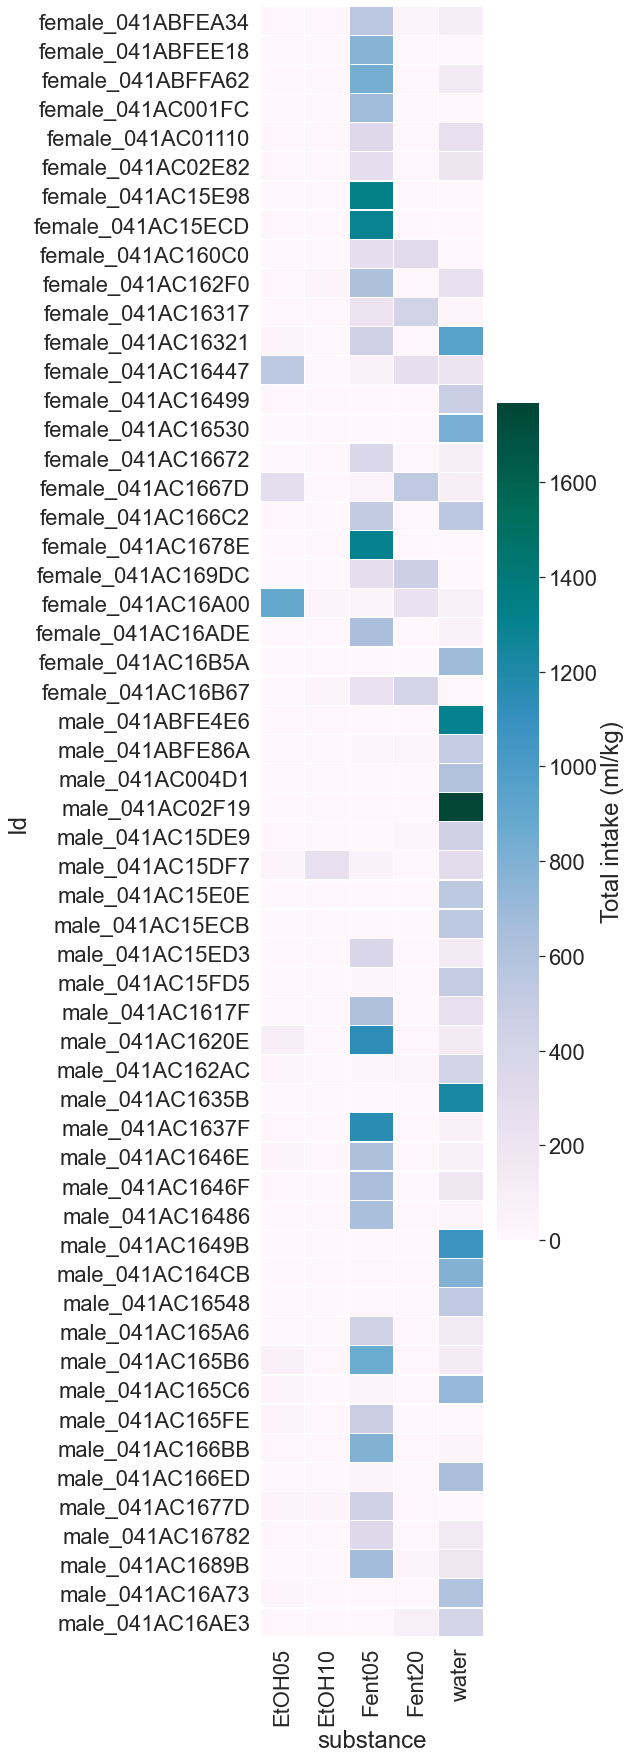

In [116]:
sns.set(font_scale=2)
groupby = data_VDM_total_sub.pivot('Id', 'substance', "intake_ml_kg")
plt.figure(figsize=(5,30))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, 
                     cbar_kws={'label': 'Total intake (ml/kg)'})

#plt.xlabel('Bottle')
plt.show()

## raster

In [117]:
data_VDM_start.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,RFID_days,VDM_days,Processed_2023,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,VDM_day_count,VDM_min_count,VDM_sec_count,VDM_hour_count_running,VDM_min_count_running,VDM_sec_count_running,ld_seg,day,ld_cycle,ld_day,VDM_drink,Cage_VDM_update,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,VDM_RFID_timediff,VDM_RFID_timediff_bool,substance,Id,intake_ml_kg,zeitgeber,zeit_quart
0,0,0,0,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,53,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 21:54:01,drink_1,0.021,2022-10-10 21:54:01,1.665439e+09,2022-10-10,10,21:54:01,21,54,1,0,1314,78841,-3,-126,-7619,dark_pm,0,dark,1,VDM_EtOH05,1,25.797,041AC15ED3,etoh_05,2022-10-10 21:53:51.171993600,2022-10-10 21:54:16.968993600,0.000000,same,EtOH05,male_041AC15ED3,0.739437,16,3.0
2,2,2,2,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,235,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/11/22 20:37:46,drink_1,0.021,2022-10-11 20:37:46,1.665521e+09,2022-10-11,11,20:37:46,20,37,46,1,1237,74266,20,1237,74206,dark_pm,1,dark,2,VDM_EtOH05,1,21.541,041AC15ED3,etoh_05,2022-10-11 20:37:28.550985600,2022-10-11 20:37:50.091985600,0.000000,same,EtOH05,male_041AC15ED3,0.739437,15,3.0
12,12,12,12,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,386,w_e10_f20_w_e5_f5_mf_221010.csv,1,10/11/22 05:08:47,drink_2,0.021,2022-10-11 05:08:47,1.665465e+09,2022-10-11,11,05:08:47,5,8,47,1,308,18527,5,308,18467,dark_am,1,dark,1,VDM_EtOH10,1,15.162,041AC15ED3,etoh_10,2022-10-11 05:08:45.227990400,2022-10-11 05:09:00.389990400,0.000000,same,EtOH10,male_041AC15ED3,0.739437,24,NaN
13,13,13,13,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,3484,w_e10_f20_w_e5_f5_mf_221010.csv,1,10/12/22 21:08:31,drink_2,0.021,2022-10-12 21:08:31,1.665609e+09,2022-10-12,12,21:08:31,21,8,31,2,1268,76111,45,2708,162451,dark_pm,2,dark,3,VDM_EtOH10,1,0.075,041AC15ED3,etoh_10,2022-10-12 21:08:30.294988800,2022-10-12 21:08:30.369988800,0.630011,diff,EtOH10,male_041AC15ED3,0.739437,16,3.0
14,14,14,14,poly,six_four,22.10.10,na,1,041AC15ED3,2138,NaN,na,male,4,28.4,NaN,NaN,NaN,NaN,NaN,NaN,9756,w_e10_f20_w_e5_f5_mf_221010.csv,1,10/13/22 21:27:42,drink_2,0.021,2022-10-13 21:27:42,1.665696e+09,2022-10-13,13,21:27:42,21,27,42,3,1287,77262,69,4167,250002,dark_pm,3,dark,4,VDM_EtOH10,1,18.466,041AC15ED3,etoh_10,2022-10-13 21:27:37.946966400,2022-10-13 21:27:56.412966400,0.000000,same,EtOH10,male_041AC15ED3,0.739437,16,3.0


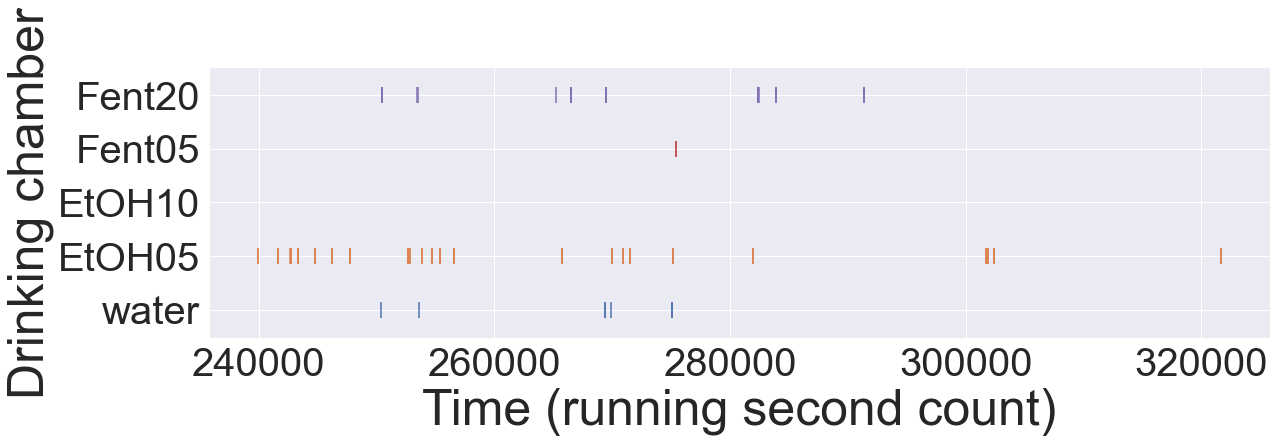

In [118]:
mice = ['041AC1620E', '041AC15DE9', '041AC16321', '041AC16A00', ]
data_idivid = data_VDM_start[data_VDM_start['IdRFID']==mice[3]]
data_idivid = data_idivid[data_idivid['ld_day']==4]
colorCodes = ['C{}'.format(i) for i in range(5)]

param = 'VDM_sec_count_running'
data_1 = data_idivid[data_idivid['substance'] == 'water'][param].values
data_2 = data_idivid[data_idivid['substance'] == 'EtOH05'][param].values
data_3 = data_idivid[data_idivid['substance'] == 'EtOH10'][param].values
data_4 = data_idivid[data_idivid['substance'] == 'Fent05'][param].values
data_5 = data_idivid[data_idivid['substance'] == 'Fent20'][param].values

data_array = np.array([data_1, data_2, data_3, data_4, data_5])

# Draw a spike raster plot
plt.figure(figsize=(19,5))
params = {'axes.labelsize': 75,
          'axes.titlesize': 75}
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
plt.rcParams.update(params)
plt.yticks([0,1,2,3,4], 
           ['water', 'EtOH05', 'EtOH10', 'Fent05', 'Fent20'])
plt.eventplot(data_array, color=colorCodes, linelengths = 0.3) 
plt.xlabel('Time (running second count)', fontsize=50)
plt.ylabel('Drinking chamber', fontsize=50)

plt.show()

## preference

#### total by substance

In [128]:
data_summary_vol = data_VDM_total_sub.set_index(['IdRFID', 'Sex', 
                                  'substance'])[['intake_ml_kg']].unstack(-1).reset_index()

data_summary_vol.columns = ['IdRFID', 'Sex', 
                        'EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water',]

data_summary_vol.replace(np.nan, 0, inplace=True)

data_summary_vol['total_alcohol_intake'] = data_summary_vol['EtOH05'] + data_summary_vol['EtOH10'] 
data_summary_vol['total_fent_intake'] = data_summary_vol['Fent05'] + data_summary_vol['Fent20'] 

data_summary_vol['overall_alcohol_pref'] = data_summary_vol['total_alcohol_intake'] / (data_summary_vol['total_alcohol_intake'] + data_summary_vol['water'])
data_summary_vol['overall_fent_pref'] = data_summary_vol['total_fent_intake'] / (data_summary_vol['total_fent_intake'] + data_summary_vol['water'])

data_summary_vol['DP_alcohol'] =  ((data_summary_vol['EtOH05']*.05) + (data_summary_vol['EtOH10']*.1))  \
/ (data_summary_vol['EtOH05'] + data_summary_vol['EtOH10'])

data_summary_vol['DP_fent'] =  ((data_summary_vol['Fent05']*.05) + (data_summary_vol['Fent20']*.2))  \
/ (data_summary_vol['Fent05'] + data_summary_vol['Fent20'])

data_summary_vol.replace(np.nan, 0, inplace=True)

data_summary_vol.head()

,IdRFID,Sex,EtOH05,EtOH10,Fent05,Fent20,water,total_alcohol_intake,total_fent_intake,overall_alcohol_pref,overall_fent_pref,DP_alcohol,DP_fent
0,041ABFE4E6,male,0.761246,1.660900,4.671280,0.000000,1307.993080,2.422145,4.671280,0.001848,0.003559,0.084286,0.050000
1,041ABFE86A,male,5.147059,0.992647,21.985294,21.176471,491.286765,6.139706,43.161765,0.012343,0.080759,0.058084,0.123595
2,041ABFEA34,female,10.312500,16.875000,556.875000,38.437500,104.062500,27.187500,595.312500,0.207143,0.851206,0.081034,0.059685
3,041ABFEE18,female,4.158416,2.079208,767.227723,4.158416,14.554455,6.237624,771.386139,0.300000,0.981481,0.066667,0.050809
4,041ABFFA62,female,2.333333,0.000000,829.500000,19.833333,137.666667,2.333333,849.333333,0.016667,0.860520,0.050000,0.053503


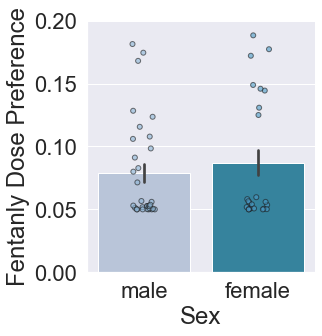

Ttest_indResult(statistic=0.6743823952157509, pvalue=0.5029452037617395)

In [129]:
g = sns.catplot(x='Sex', y='DP_fent', data=data_summary_vol,  kind='bar', height=5, aspect=1,
            ci=68, palette='PuBuGn')

# map data to stripplot
g.map(sns.stripplot, 'Sex', 'DP_fent', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)
plt.ylabel('Fentanly Dose Preference')
plt.ylim(0,.2)
plt.show()

male = data_summary_vol[data_summary_vol['Sex']=='male']['DP_fent']
female = data_summary_vol[data_summary_vol['Sex']=='female']['DP_fent']
stats.ttest_ind(female, male)

#### ld total by substance

In [130]:
data_summary_vol_day = data_VDM_total_sub_day.set_index(['IdRFID', 'Sex', 'ld_day', 
                                  'substance'])[['intake_ml_kg']].unstack(-1).reset_index()

data_summary_vol_day.columns = ['IdRFID', 'Sex', 'ld_day',
                        'EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water',]

data_summary_vol_day.replace(np.nan, 0, inplace=True)

data_summary_vol_day['total_alcohol_intake'] = data_summary_vol_day['EtOH05'] + data_summary_vol_day['EtOH10'] 
data_summary_vol_day['total_fent_intake'] = data_summary_vol_day['Fent05'] + data_summary_vol_day['Fent20'] 

data_summary_vol_day['overall_alcohol_pref'] = data_summary_vol_day['total_alcohol_intake'] / (data_summary_vol_day['total_alcohol_intake'] + data_summary_vol_day['water'])
data_summary_vol_day['overall_fent_pref'] = data_summary_vol_day['total_fent_intake'] / (data_summary_vol_day['total_fent_intake'] + data_summary_vol_day['water'])

data_summary_vol_day['DP_alcohol'] =  ((data_summary_vol_day['EtOH05']*.05) + (data_summary_vol_day['EtOH10']*.1))  \
/ (data_summary_vol_day['EtOH05'] + data_summary_vol_day['EtOH10'])

data_summary_vol_day['DP_fent'] =  ((data_summary_vol_day['Fent05']*.05) + (data_summary_vol_day['Fent20']*.2))  \
/ (data_summary_vol_day['Fent05'] + data_summary_vol_day['Fent20'])

data_summary_vol_day.replace(np.nan, 0, inplace=True)
data_summary_vol_day.head()

,IdRFID,Sex,ld_day,EtOH05,EtOH10,Fent05,Fent20,water,total_alcohol_intake,total_fent_intake,overall_alcohol_pref,overall_fent_pref,DP_alcohol,DP_fent
0,041ABFE4E6,male,1,0.000000,0.00000,1.868512,0.0,121.245675,0.000000,1.868512,0.000000,0.015177,0.00,0.05
1,041ABFE4E6,male,2,0.761246,0.00000,1.868512,0.0,213.425606,0.761246,1.868512,0.003554,0.008679,0.05,0.05
2,041ABFE4E6,male,3,0.000000,0.00000,0.000000,0.0,213.425606,0.000000,0.000000,0.000000,0.000000,0.00,0.00
3,041ABFE4E6,male,4,0.000000,0.83045,0.000000,0.0,175.224913,0.830450,0.000000,0.004717,0.000000,0.10,0.00
4,041ABFE4E6,male,5,0.000000,0.83045,0.934256,0.0,177.750865,0.830450,0.934256,0.004650,0.005229,0.10,0.05


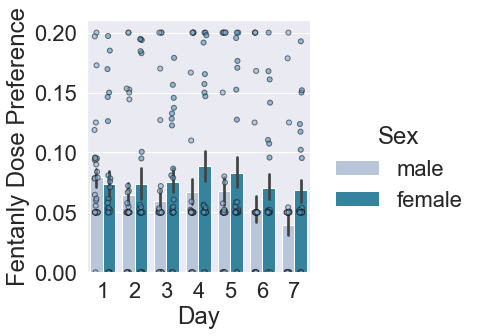

In [131]:
g= sns.catplot(x='ld_day', y='DP_fent', data=data_summary_vol_day,  kind='bar', height=5, aspect=1,
            ci=68, hue='Sex', palette='PuBuGn')

# map data to DP_fent
g.map(sns.stripplot, 'ld_day', 'DP_fent', 'Sex', 
      palette=sns.color_palette('PuBuGn')[2:4], dodge=True, alpha=0.6, ec='k', linewidth=1)

#plt.ylim(0,1250)
plt.xlabel('Day')
plt.ylabel('Fentanly Dose Preference')
plt.show()

In [132]:
dv = 'DP_fent'

#RM using Pingouin
aov = pg.mixed_anova(dv=dv, within='ld_day', between='Sex', subject='IdRFID', data=data_summary_vol_day)
pg.print_table(aov)

#posthocs
posthocs = pg.pairwise_ttests(dv=dv, within='ld_day', between='Sex',
                              subject='IdRFID', data=data_summary_vol_day, padjust='fdr_bh')
pg.print_table(posthocs)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
Sex          0.021      1     54  0.021  1.669    0.202  0.030  nan
ld_day       0.028      6    324  0.005  2.706    0.014  0.048    0.746
Interaction  0.010      6    324  0.002  0.956    0.455  0.017  nan


POST HOC TESTS

Contrast      ld_day    A     B       Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
------------  --------  ----  ------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ------  --------
ld_day        -         1     2       True      True           1.116  55.000  two-sided    0.269     0.427  fdr_bh       0.263     0.150
ld_day        -         1     3       True      True           1.476  55.000  two-sided    0.146     0.340  fdr_bh       0.405     0.197
ld_day        -         1     4       True      True           0.0

#### daily and hourly total by substance

In [133]:
data_summary_vol_day = data_VDM_total_sub_day_hour.set_index(['IdRFID', 'Sex', 'ld_day', 'zeitgeber',
                                  'substance'])[['intake_ml_kg']].unstack(-1).reset_index()

data_summary_vol_day.columns = ['IdRFID', 'Sex', 'ld_day', 'zeitgeber',
                        'EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water',]

data_summary_vol_day.replace(np.nan, 0, inplace=True)

data_summary_vol_day['total_alcohol_intake'] = data_summary_vol_day['EtOH05'] + data_summary_vol_day['EtOH10'] 
data_summary_vol_day['total_fent_intake'] = data_summary_vol_day['Fent05'] + data_summary_vol_day['Fent20'] 

data_summary_vol_day['overall_alcohol_pref'] = data_summary_vol_day['total_alcohol_intake'] / (data_summary_vol_day['total_alcohol_intake'] + data_summary_vol_day['water'])
data_summary_vol_day['overall_fent_pref'] = data_summary_vol_day['total_fent_intake'] / (data_summary_vol_day['total_fent_intake'] + data_summary_vol_day['water'])

data_summary_vol_day['DP_alcohol'] =  ((data_summary_vol_day['EtOH05']*.05) + (data_summary_vol_day['EtOH10']*.1))  \
/ (data_summary_vol_day['EtOH05'] + data_summary_vol_day['EtOH10'])

data_summary_vol_day['DP_fent'] =  ((data_summary_vol_day['Fent05']*.05) + (data_summary_vol_day['Fent20']*.2))  \
/ (data_summary_vol_day['Fent05'] + data_summary_vol_day['Fent20'])


data_summary_vol_day.replace(np.nan, 0, inplace=True)

data_summary_vol_day.head()

,IdRFID,Sex,ld_day,zeitgeber,EtOH05,EtOH10,Fent05,Fent20,water,total_alcohol_intake,total_fent_intake,overall_alcohol_pref,overall_fent_pref,DP_alcohol,DP_fent
0,041ABFE4E6,male,1,1,0.0,0.0,0.0,0.0,7.474048,0.0,0.0,0.0,0.0,0.0,0.0
1,041ABFE4E6,male,1,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,041ABFE4E6,male,1,3,0.0,0.0,0.0,0.0,5.813149,0.0,0.0,0.0,0.0,0.0,0.0
3,041ABFE4E6,male,1,4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,041ABFE4E6,male,1,5,0.0,0.0,0.0,0.0,11.626298,0.0,0.0,0.0,0.0,0.0,0.0


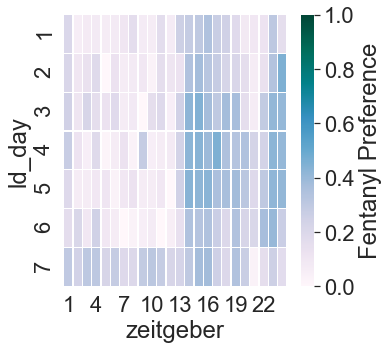

In [134]:
d = data_summary_vol_day[data_summary_vol_day['Sex']=='male']

groupby = d.groupby(['ld_day', 'zeitgeber'])['overall_fent_pref'].mean().reset_index()


sns.set(font_scale=2)
groupby = groupby.pivot('ld_day', 'zeitgeber', "overall_fent_pref")
plt.figure(figsize=(5,5))
ax = sns.heatmap(groupby, cmap="PuBuGn", linewidths=.25, vmax=1,
                     cbar_kws={'label': 'Fentanyl Preference'})

#plt.xlabel('Bottle')
plt.show()